In [1]:
# 隨機從dataset中挑選N筆資料
from os import walk
from os.path import join
from os import stat
import random
import hashlib
import time

mypath = "D:\Download\enron"

# store all the fullpath of files in the root directory
file_names = []

# only store files size bigger than 5K
for root, dirs, files in walk(mypath):
    for f in files:
        fullpath = join(root, f)
        if(stat(fullpath).st_size >= 5000):
            file_names.append(fullpath)

In [2]:
upload_files = random.sample(file_names, k = 1000)
check_files = random.choices(file_names, k = 200)

In [3]:
cloud_hash = []
check_hash = []
response_list = {}
dirty_list = []

In [4]:
def upload_file(upload_list, chunk_size):
    for file in upload_list:
        with open(file, 'rb') as f:
            text = f.read()
        f.close()

        for i in range(0, len(text), chunk_size):
            cloud_hash.append(hashlib.sha256(text[i: i+chunk_size]).hexdigest())
        
def check_file(check_list, chunk_size):
    for file in check_list:
        with open(file, 'rb') as f:
            text = f.read()
        f.close()
        
        for i in range(0, len(text), chunk_size):
            check_hash.append(hashlib.sha256(text[i: i+chunk_size]).hexdigest())
        
        if len(check_hash) % 2 != 0:
            check_hash.append(random.choice(check_hash))

In [5]:
def set_response_list(percent):
    dirty = random.sample(cloud_hash, k = int(percent * len(cloud_hash)))
    
    for chunk in dirty:
        status = random.randint(1, 2)
        response = random.randint(1, 2)
        if response == 1:
            response_list.update({chunk: {status: response}})
            if status == 1:
                response_list[chunk].update({2: 2})
            else:
                response_list[chunk].update({1: 2})
        elif random.random() >= 0.5:
            response_list.update({chunk: {status: response}})
            if status == 1:
                response_list[chunk].update({2: random.randint(1, 2)})
            else:
                response_list[chunk].update({1: random.randint(1, 2)})
        else:
            response_list.update({chunk: {status: response}})
            if status == 1:
                response_list[chunk].update({2: 0})
            else:
                response_list[chunk].update({1: 0})
                
def set_dirty_list(percent):
    dirty_list.extend(random.sample(cloud_hash, k = int(percent * len(cloud_hash))))

In [6]:
def new():
    query = list(set(check_hash.copy()))
    print("after dedup chunk amount:", len(query))
    upload_amount = 0
    
    flex_e0 = []    # flexible, inexist
    flex_e1 = []    # flexible, exist
    fix_s1_e0 = []    # (1,0) -> 1, (1,1) -> 2
    fix_s1_e1 = []    # (1,0) -> 1, (1,1) -> 2
    fix_s2_e0 = []    # (1,1) -> 1, (1,0) -> 2
    fix_s2_e1 = []    # (1,1) -> 1, (1,0) -> 2
    ran_s1_e0 = []    # (1,0) -> RARE, (1,1) -> 2
    ran_s1_e1 = []    # (1,0) -> RARE, (1,1) -> 2
    ran_s2_e0 = []    # (1,1) -> RARE, (1,0) -> 2
    ran_s2_e1 = []    # (1,1) -> RARE, (1,0) -> 2
    fix_2 = []    # fix, all resposne 2
    
    for chunk in query:
        if chunk not in response_list:
            if chunk in cloud_hash:
                flex_e1.append(chunk)
            else:
                flex_e0.append(chunk)
        else:
            if (1 in response_list[chunk].values()) and (1 == list(response_list[chunk].values())[0]) and (chunk not in cloud_hash):
                fix_s1_e0.append(chunk)
            elif (1 in response_list[chunk].values()) and (1 == list(response_list[chunk].values())[0]) and (chunk in cloud_hash):
                fix_s1_e1.append(chunk)
            elif (1 in response_list[chunk].values()) and (1 == list(response_list[chunk].values())[1]) and (chunk not in cloud_hash):
                fix_s2_e0.append(chunk)
            elif (1 in response_list[chunk].values()) and (1 == list(response_list[chunk].values())[1]) and (chunk in cloud_hash):
                fix_s2_e1.append(chunk)
            elif (0 in response_list[chunk].values()) and (0 == list(response_list[chunk].values())[0]) and (chunk not in cloud_hash):
                ran_s1_e0.append(chunk)
            elif (0 in response_list[chunk].values()) and (0 == list(response_list[chunk].values())[0]) and (chunk in cloud_hash):
                ran_s1_e1.append(chunk)
            elif (0 in response_list[chunk].values()) and (0 == list(response_list[chunk].values())[1]) and (chunk not in cloud_hash):
                ran_s2_e0.append(chunk)
            elif (0 in response_list[chunk].values()) and (0 == list(response_list[chunk].values())[1]) and (chunk in cloud_hash):
                ran_s1_e1.append(chunk)
            else:
                fix_2.append(chunk)
                
    while len(fix_s1_e0) > 0:    # (1,0) -> 1
        if len(fix_s1_e1) > 0:
            fix_s1_e0.pop()
            fix_s1_e1.pop()
            upload_amount += 1
        elif len(ran_s1_e1) > 0:
            fix_s1_e0.pop()
            ran_s1_e1.pop()
            upload_amount += 1
        elif len(flex_e1) > 0:
            fix_s1_e0.pop()
            flex_e1.pop()
            upload_amount += 1
        else:
            break
            
    while len(fix_s1_e1) > 0:
        if len(fix_s1_e0) > 0:
            fix_s1_e1.pop()
            fix_s1_e0.pop()
            upload_amount += 1
        elif len(ran_s1_e0) > 0:
            fix_s1_e1.pop()
            ran_s1_e0.pop()
            upload_amount += 1
        elif len(flex_e0) > 0:
            fix_s1_e1.pop()
            flex_e0.pop()
            upload_amount += 1
        else:
            break
            
    while len(fix_s2_e1) > 0:    # (1,1) -> 1
        if len(fix_s2_e1) >= 2:
            fix_s2_e1.pop()
            fix_s2_e1.pop()
            upload_amount += 1
        elif len(ran_s2_e1) > 0:
            fix_s2_e1.pop()
            ran_s2_e1.pop()
            upload_amount += 1
        elif len(flex_e1) > 0:
            fix_s2_e1.pop()
            flex_e1.pop()
            upload_amount += 1
        else:
            break
        
    while len(ran_s1_e0) > 0:    # (1,0) -> 1 or RARE
        if len(fix_s1_e1) > 0:
            ran_s1_e0.pop()
            fix_s1_e1.pop()
            upload_amount += 1
        elif len(ran_s1_e1) > 0:
            ran_s1_e0.pop()
            ran_s1_e1.pop()
            upload_amount += random.randint(1, 2)
        elif len(flex_e1) > 0:
            ran_s1_e0.pop()
            flex_e1.pop()
            upload_amount += random.randint(1, 2)
        else:
            break
            
    while len(ran_s1_e1) > 0:    # (1,0) -> 1 or RARE
        if len(fix_s1_e0) > 0:
            ran_s1_e1.pop()
            fix_s1_e0.pop()
            upload_amount += 1
        elif len(ran_s1_e0) > 0:
            ran_s1_e1.pop()
            ran_s1_e0.pop()
            upload_amount += random.randint(1, 2)
        elif len(flex_e0) > 0:
            ran_s1_e1.pop()
            flex_e0.pop()
            upload_amount += random.randint(1, 2)
        else:
            break
            
    while len(ran_s2_e1) > 0:    # (1,1) -> 1 or RARE
        if len(fix_s2_e1) > 0:
            ran_s2_e1.pop()
            fix_s2_e1.pop()
            upload_amount += 1
        elif len(ran_s2_e1) >= 2:
            ran_s2_e1.pop()
            ran_s2_e1.pop()
            upload_amount += random.randint(1, 2)
        elif len(flex_e1) > 0:
            ran_s2_e1.pop()
            flex_e1.pop()
            upload_amount += random.randint(1, 2)
        else:
            break
            
    while len(flex_e0) > 0:    # return 1 or RARE
        if len(fix_s1_e1) > 0:
            flex_e0.pop()
            fix_s1_e1.pop()
            upload_amount += 1
        elif len(ran_s1_e1) > 0:
            flex_e0.pop()
            ran_s1_e1.pop()
            upload_amount += random.randint(1, 2)
        elif len(flex_e1) > 0:
            flex_e0.pop()
            flex_e1.pop()
            upload_amount += random.randint(1, 2)
        else:
            break
            
    while len(flex_e1) > 0:    # return 1 or RARE
        if len(fix_s1_e0) > 0:
            flex_e1.pop()
            fix_s1_e0.pop()
            upload_amount += 1
        elif len(fix_s2_e1) > 0:
            flex_e1.pop()
            fix_s2_e1.pop()
            upload_amount += 1
        elif len(ran_s1_e0) > 0:
            flex_e1.pop()
            ran_s1_e0.pop()
            upload_amount += random.randint(1, 2)
        elif len(ran_s2_e1) > 0:
            flex_e1.pop()
            ran_s2_e1.pop()
            upload_amount += random.randint(1, 2)
        elif len(flex_e0) > 0:
            flex_e1.pop()
            flex_e0.pop()
            upload_amount += random.randint(1, 2)
        elif len(flex_e1) >= 2:
            flex_e1.pop()
            flex_e1.pop()
            upload_amount += random.randint(1, 2)
        else:
            break
            
    remain_list = flex_e0 + flex_e1 + fix_s1_e0 + fix_s1_e1 + fix_s2_e0 + fix_s2_e1 + ran_s1_e0 + ran_s1_e1 + ran_s2_e0 + ran_s2_e1 + fix_2
    upload_amount += len(remain_list)
    
    return upload_amount

In [7]:
def rare():
    upload_amount = 0
    cloud = cloud_hash.copy()
    
    for i in range(0, len(check_hash), 2):
        if (check_hash[i] in dirty_list) or (check_hash[i+1] in dirty_list):
            upload_amount += 2
            cloud.append(check_hash[i])
            cloud.append(check_hash[i+1])
        elif (check_hash[i] not in cloud) and (check_hash[i+1] not in cloud):
            upload_amount += 2
            cloud.append(check_hash[i])
            cloud.append(check_hash[i+1])
        else:
            res = random.randint(1, 2)
            upload_amount += res
            if res == 1:
                if check_hash[i] not in cloud:
                    cloud.append(check_hash[i])
                if check_hash[i+1] not in cloud:
                    cloud.append(check_hash[i+1])
            else:
                cloud.append(check_hash[i])
                cloud.append(check_hash[i+1])
    
    return upload_amount

def zeus_plus(threshold):
    upload_amount = 0
    cloud = cloud_hash.copy()
    
    threshold_list = [i for i in range(1, threshold + 1)]
    cloud_thres = random.choices(threshold_list, k = len(cloud))
    
    for i in range(0, len(check_hash), 2):
        if (check_hash[i] in dirty_list) or (check_hash[i+1] in dirty_list):
            upload_amount += 2
        elif (check_hash[i] not in cloud) and (check_hash[i+1] not in cloud):
            upload_amount += 2
            cloud.append(check_hash[i])
            cloud_thres.append(random.randint(1, threshold))
            cloud.append(check_hash[i+1])
            cloud_thres.append(random.randint(1, threshold))
        elif (check_hash[i] in cloud) and (cloud_thres[cloud.index(check_hash[i])] > 1) and (check_hash[i+1] not in cloud):
            upload_amount += 2
            cloud_thres[cloud.index(check_hash[i])] -= 1
            cloud.append(check_hash[i+1])
            cloud_thres.append(random.randint(1, threshold))
        elif (check_hash[i] not in cloud) and (check_hash[i+1] in cloud) and (cloud_thres[cloud.index(check_hash[i+1])] > 1):
            upload_amount += 2
            cloud.append(check_hash[i])
            cloud_thres.append(random.randint(1, threshold))
            cloud_thres[cloud.index(check_hash[i+1])] -= 1
        elif (check_hash[i]  in cloud) and (cloud_thres[cloud.index(check_hash[i])] > 1) and (check_hash[i+1] in cloud) and (cloud_thres[cloud.index(check_hash[i+1])] > 1):
            upload_amount += 2
            cloud_thres[cloud.index(check_hash[i])] -= 1
            cloud_thres[cloud.index(check_hash[i+1])] -= 1
        else:
            upload_amount += 1
            if check_hash[i] not in cloud:
                cloud.append(check_hash[i])
                cloud_thres.append(random.randint(1, threshold))
            if check_hash[i+1] not in cloud:
                cloud.append(check_hash[i+1])
                cloud_thres.append(random.randint(1, threshold))
    
    return upload_amount

def dedup():
    upload_amount = 0
    cloud = cloud_hash.copy()
    
    for chunk in check_hash:
        if chunk not in cloud:
            upload_amount += 1
            cloud.append(chunk)
    
    return upload_amount

In [8]:
def rrrare():
    upload_amount = 0
    cloud = cloud_hash.copy()
    check = check_hash.copy()
    random.shuffle(check)
    
    for i in range(0, len(check), 2):
        if (check[i] in dirty_list) or (check[i+1] in dirty_list):
            upload_amount += 2
        elif (check[i] not in cloud) and (check[i+1] not in cloud):
            upload_amount += 2
            cloud.append(check[i])
            cloud.append(check[i+1])
        else:
            res = random.randint(1, 2)
            upload_amount += res
            if check_hash[i] not in cloud:
                cloud.append(check[i])
            if check_hash[i+1] not in cloud:
                cloud.append(check[i+1])
        
    return upload_amount

def rrare():
    upload_amount = 0
    cloud = cloud_hash.copy()
    query = list(set(check_hash.copy()))
    
    if len(query) % 2 != 0:
        query.append(random.choice(query))
    
    exist = []
    absent = []
    dirty = []
    
    for chunk in query:
        if chunk in dirty_list:
            dirty.append(chunk)
        elif chunk in cloud:
            exist.append(chunk)
        else:
            absent.append(chunk)
    
    random.shuffle(exist)
    random.shuffle(absent)
    random.shuffle(dirty)
    
    if len(dirty) % 2 == 0:
        upload_amount += len(dirty)
    else:
        if len(absent) > 0:
            cloud.append(absent.pop())
            upload_amount += len(dirty) + 1
        else:
            exist.pop()
            upload_amount += len(dirty) + 1
            
    if len(absent) >= len(exist):
        while len(exist) > 0:
            exist.pop()
            cloud.append(absent.pop())
            upload_amount += random.randint(1, 2)
        
        cloud.extend(absent)
        upload_amount += len(absent)
    else:
        while len(absent) > 0:
            cloud.append(absent.pop())
            exist.pop()
            upload_amount += random.randint(1, 2)
        
        while len(exist) > 1:
            exist.pop()
            exist.pop()
            upload_amount += random.randint(1, 2)
            
    return upload_amount

In [9]:
def rare_rl():
    upload_amount = 0
    cloud = cloud_hash.copy()
    check = check_hash.copy()
    
    for i in range(0, len(check), 2):
        if (check[i] in response_list) or (check[i+1] in response_list):
            if check[i] in response_list:
                if tuple(response_list[check[i]].values()) == (2,2):
                    upload_amount += 2
                    if check[i+1] not in cloud:
                        cloud.append(check[i+1])
                elif tuple(response_list[check[i]].values()) == (1,2):
                    if check[i+1] not in cloud:
                        upload_amount += 1
                        cloud.append(check[i+1])
                    else:
                        upload_amount += 2
                elif tuple(response_list[check[i]].values()) == (2,1):
                    if check[i+1] not in cloud:
                        upload_amount += 2
                        cloud.append(check[i+1])
                    elif check[i+1] not in response_list:
                        upload_amount += 1
                    else:
                        if (tuple(response_list[check[i+1]].values()) == (2,1)) or (tuple(response_list[check[i+1]].values()) == (2,0)):
                            upload_amount += 1
                        else:
                            upload_amount += 2
                elif tuple(response_list[check[i]].values()) == (0,2):
                    if check[i+1] not in cloud:
                        upload_amount += random.randint(1, 2)
                        cloud.append(check[i+1])
                    else:
                        upload_amount += 2
                elif tuple(response_list[check[i]].values()) == (2,0):
                    if check[i+1] not in cloud:
                        upload_amount += 2
                        cloud.append(check[i+1])
                    elif check[i+1] not in response_list:
                        upload_amount += random.randint(1, 2)
                    else:
                        if tuple(response_list[check[i+1]].values()) == (2,1):
                            upload_amount += 1
                        elif tuple(response_list[check[i+1]].values()) == (2,0):
                            upload_amount += random.randint(1, 2)
                        else:
                            upload_amount += 2
            else:
                if tuple(response_list[check[i+1]].values()) == (2,2):
                    upload_amount += 2
                    if check[i] not in cloud:
                        cloud.append(check[i])
                elif tuple(response_list[check[i+1]].values()) == (1,2):
                    if check[i] not in cloud:
                        upload_amount += 1
                        cloud.append(check[i])
                    else:
                        upload_amount += 2
                elif tuple(response_list[check[i+1]].values()) == (2,1):
                    if check[i] not in cloud:
                        upload_amount += 2
                        cloud.append(check[i])
                    elif check[i] not in response_list:
                        upload_amount += 1
                    else:
                        if (tuple(response_list[check[i]].values()) == (2,1)) or (tuple(response_list[check[i]].values()) == (2,0)):
                            upload_amount += 1
                        else:
                            upload_amount += 2
                elif tuple(response_list[check[i+1]].values()) == (0,2):
                    if check[i] not in cloud:
                        upload_amount += random.randint(1, 2)
                        cloud.append(check[i])
                    else:
                        upload_amount += 2
                elif tuple(response_list[check[i+1]].values()) == (2,0):
                    if check[i] not in cloud:
                        upload_amount += 2
                        cloud.append(check[i])
                    elif check[i] not in response_list:
                        upload_amount += random.randint(1, 2)
                    else:
                        if tuple(response_list[check[i]].values()) == (2,1):
                            upload_amount += 1
                        elif tuple(response_list[check[i]].values()) == (2,0):
                            upload_amount += random.randint(1, 2)
                        else:
                            upload_amount += 2
        else:
            if (check[i] not in cloud) and (check[i+1] not in cloud):
                upload_amount += 2
                cloud.append(check[i])
                cloud.append(check[i+1])
            else:
                upload_amount += random.randint(1, 2)
                if check[i] not in cloud:
                    cloud.append(check[i])
                if check[i+1] not in cloud:
                    cloud.append(check[i+1])
    
    return upload_amount

In [10]:
def urrl():
    upload_amount = 0
    cloud = cloud_hash.copy()
    check = check_hash.copy()
    random.shuffle(check)
    
    for i in range(0, len(check), 2):
        if (check[i] in response_list) or (check[i+1] in response_list):
            if check[i] in response_list:
                if tuple(response_list[check[i]].values()) == (2,2):
                    upload_amount += 2
                    if check[i+1] not in cloud:
                        cloud.append(check[i+1])
                elif tuple(response_list[check[i]].values()) == (1,2):
                    if check[i+1] not in cloud:
                        upload_amount += 1
                        cloud.append(check[i+1])
                    else:
                        upload_amount += 2
                elif tuple(response_list[check[i]].values()) == (2,1):
                    if check[i+1] not in cloud:
                        upload_amount += 2
                        cloud.append(check[i+1])
                    elif check[i+1] not in response_list:
                        upload_amount += 1
                    else:
                        if (tuple(response_list[check[i+1]].values()) == (2,1)) or (tuple(response_list[check[i+1]].values()) == (2,0)):
                            upload_amount += 1
                        else:
                            upload_amount += 2
                elif tuple(response_list[check[i]].values()) == (0,2):
                    if check[i+1] not in cloud:
                        upload_amount += random.randint(1, 2)
                        cloud.append(check[i+1])
                    else:
                        upload_amount += 2
                elif tuple(response_list[check[i]].values()) == (2,0):
                    if check[i+1] not in cloud:
                        upload_amount += 2
                        cloud.append(check[i+1])
                    elif check[i+1] not in response_list:
                        upload_amount += random.randint(1, 2)
                    else:
                        if tuple(response_list[check[i+1]].values()) == (2,1):
                            upload_amount += 1
                        elif tuple(response_list[check[i+1]].values()) == (2,0):
                            upload_amount += random.randint(1, 2)
                        else:
                            upload_amount += 2
            else:
                if tuple(response_list[check[i+1]].values()) == (2,2):
                    upload_amount += 2
                    if check[i] not in cloud:
                        cloud.append(check[i])
                elif tuple(response_list[check[i+1]].values()) == (1,2):
                    if check[i] not in cloud:
                        upload_amount += 1
                        cloud.append(check[i])
                    else:
                        upload_amount += 2
                elif tuple(response_list[check[i+1]].values()) == (2,1):
                    if check[i] not in cloud:
                        upload_amount += 2
                        cloud.append(check[i])
                    elif check[i] not in response_list:
                        upload_amount += 1
                    else:
                        if (tuple(response_list[check[i]].values()) == (2,1)) or (tuple(response_list[check[i]].values()) == (2,0)):
                            upload_amount += 1
                        else:
                            upload_amount += 2
                elif tuple(response_list[check[i+1]].values()) == (0,2):
                    if check[i] not in cloud:
                        upload_amount += random.randint(1, 2)
                        cloud.append(check[i])
                    else:
                        upload_amount += 2
                elif tuple(response_list[check[i+1]].values()) == (2,0):
                    if check[i] not in cloud:
                        upload_amount += 2
                        cloud.append(check[i])
                    elif check[i] not in response_list:
                        upload_amount += random.randint(1, 2)
                    else:
                        if tuple(response_list[check[i]].values()) == (2,1):
                            upload_amount += 1
                        elif tuple(response_list[check[i]].values()) == (2,0):
                            upload_amount += random.randint(1, 2)
                        else:
                            upload_amount += 2
        else:
            if (check[i] not in cloud) and (check[i+1] not in cloud):
                upload_amount += 2
                cloud.append(check[i])
                cloud.append(check[i+1])
            else:
                upload_amount += random.randint(1, 2)
                if check[i] not in cloud:
                    cloud.append(check[i])
                if check[i+1] not in cloud:
                    cloud.append(check[i+1])
    
    return upload_amount

In [11]:
new_cost = []
rare_cost = []
rrare_cost = []
urrl_cost = []
rarerl_cost = []
rrrare_cost = []
zeus5_cost = []
zeus20_cost = []
zeus40_cost = []
dedup_cost = []
chunk_amount = []

new_cost_10 = []
rare_cost_10 = []
rrare_cost_10 = []
urrl_cost_10 = []
rarerl_cost_10 = []
rrrare_cost_10 = []
zeus5_cost_10 = []
zeus20_cost_10 = []
zeus40_cost_10 = []

new_cost_25 = []
rare_cost_25 = []
rrare_cost_25 = []
urrl_cost_25 = []
rarerl_cost_25 = []
rrrare_cost_25 = []
zeus5_cost_25 = []
zeus20_cost_25 = []
zeus40_cost_25 = []

new_cost_80 = []
rare_cost_80 = []
rrare_cost_80 = []
urrl_cost_80 = []
rarerl_cost_80 = []
rrrare_cost_80 = []
zeus5_cost_80 = []
zeus20_cost_80 = []
zeus40_cost_80 = []

In [44]:
cloud_hash = []
check_hash = []
dirty_list = []
response_list = {}
upload_file(upload_files, 128)
check_file(check_files, 128)
chunk_amount.append(len(check_hash))

nc = []
rc = []
rrc = []
urc = []
rrlc = []
rrrc = []
z5c = []
z20c = []
z40c = []
dc = []
for i in range(5):
    nc.append(new())
    rc.append(rare())
    rrc.append(rrare())
    urc.append(urrl())
    rrlc.append(rare_rl())
    rrrc.append(rrrare())
    z5c.append(zeus_plus(5))
    z20c.append(zeus_plus(20))
    z40c.append(zeus_plus(40))
    dc.append(dedup())
    
new_cost.append(int(sum(nc) / 5))
rare_cost.append(int(sum(rc) / 5))
rrare_cost.append(int(sum(rrc) / 5))
urrl_cost.append(int(sum(urc) / 5))
rarerl_cost.append(int(sum(rrlc) / 5))
rrrare_cost.append(int(sum(rrrc) / 5))
zeus5_cost.append(int(sum(z5c) / 5))
zeus20_cost.append(int(sum(z20c) / 5))
zeus40_cost.append(int(sum(z40c) / 5))
dedup_cost.append(int(sum(dc) / 5))

dirty_list = []
response_list = {}
set_response_list(0.1)
set_dirty_list(0.1)
nc = []
rc = []
rrc = []
urc = []
rrlc = []
rrrc = []
z5c = []
z20c = []
z40c = []
for i in range(5):
    nc.append(new())
    rc.append(rare())
    rrc.append(rrare())
    urc.append(urrl())
    rrlc.append(rare_rl())
    rrrc.append(rrrare())
    z5c.append(zeus_plus(5))
    z20c.append(zeus_plus(20))
    z40c.append(zeus_plus(40))
    
new_cost_10.append(int(sum(nc) / 5))
rare_cost_10.append(int(sum(rc) / 5))
rrare_cost_10.append(int(sum(rrc) / 5))
urrl_cost_10.append(int(sum(urc) / 5))
rarerl_cost_10.append(int(sum(rrlc) / 5))
rrrare_cost_10.append(int(sum(rrrc) / 5))
zeus5_cost_10.append(int(sum(z5c) / 5))
zeus20_cost_10.append(int(sum(z20c) / 5))
zeus40_cost_10.append(int(sum(z40c) / 5))

dirty_list = []
response_list = {}
set_response_list(0.25)
set_dirty_list(0.25)
nc = []
rc = []
rrc = []
urc = []
rrlc = []
rrrc = []
z5c = []
z20c = []
z40c = []
for i in range(5):
    nc.append(new())
    rc.append(rare())
    rrc.append(rrare())
    urc.append(urrl())
    rrlc.append(rare_rl())
    rrrc.append(rrrare())
    z5c.append(zeus_plus(5))
    z20c.append(zeus_plus(20))
    z40c.append(zeus_plus(40))
    
new_cost_25.append(int(sum(nc) / 5))
rare_cost_25.append(int(sum(rc) / 5))
rrare_cost_25.append(int(sum(rrc) / 5))
urrl_cost_25.append(int(sum(urc) / 5))
rarerl_cost_25.append(int(sum(rrlc) / 5))
rrrare_cost_25.append(int(sum(rrrc) / 5))
zeus5_cost_25.append(int(sum(z5c) / 5))
zeus20_cost_25.append(int(sum(z20c) / 5))
zeus40_cost_25.append(int(sum(z40c) / 5))

dirty_list = []
response_list = {}
set_response_list(0.8)
set_dirty_list(0.8)
nc = []
rc = []
rrc = []
urc = []
rrlc = []
rrrc = []
z5c = []
z20c = []
z40c = []
for i in range(5):
    nc.append(new())
    rc.append(rare())
    rrc.append(rrare())
    urc.append(urrl())
    rrlc.append(rare_rl())
    rrrc.append(rrrare())
    z5c.append(zeus_plus(5))
    z20c.append(zeus_plus(20))
    z40c.append(zeus_plus(40))
    
new_cost_80.append(int(sum(nc) / 5))
rare_cost_80.append(int(sum(rc) / 5))
rrare_cost_80.append(int(sum(rrc) / 5))
urrl_cost_80.append(int(sum(urc) / 5))
rarerl_cost_80.append(int(sum(rrlc) / 5))
rrrare_cost_80.append(int(sum(rrrc) / 5))
zeus5_cost_80.append(int(sum(z5c) / 5))
zeus20_cost_80.append(int(sum(z20c) / 5))
zeus40_cost_80.append(int(sum(z40c) / 5))

after dedup chunk amount: 17371
after dedup chunk amount: 17371
after dedup chunk amount: 17371
after dedup chunk amount: 17371
after dedup chunk amount: 17371
after dedup chunk amount: 17371
after dedup chunk amount: 17371
after dedup chunk amount: 17371
after dedup chunk amount: 17371
after dedup chunk amount: 17371
after dedup chunk amount: 17371
after dedup chunk amount: 17371
after dedup chunk amount: 17371
after dedup chunk amount: 17371
after dedup chunk amount: 17371
after dedup chunk amount: 17371
after dedup chunk amount: 17371
after dedup chunk amount: 17371
after dedup chunk amount: 17371
after dedup chunk amount: 17371


In [45]:
cloud_hash = []
check_hash = []
dirty_list = []
response_list = {}
upload_file(upload_files, 256)
check_file(check_files, 256)
chunk_amount.append(len(check_hash))

nc = []
rc = []
rrc = []
urc = []
rrlc = []
rrrc = []
z5c = []
z20c = []
z40c = []
dc = []
for i in range(5):
    nc.append(new())
    rc.append(rare())
    rrc.append(rrare())
    urc.append(urrl())
    rrlc.append(rare_rl())
    rrrc.append(rrrare())
    z5c.append(zeus_plus(5))
    z20c.append(zeus_plus(20))
    z40c.append(zeus_plus(40))
    dc.append(dedup())
    
new_cost.append(int(sum(nc) / 5))
rare_cost.append(int(sum(rc) / 5))
rrare_cost.append(int(sum(rrc) / 5))
urrl_cost.append(int(sum(urc) / 5))
rarerl_cost.append(int(sum(rrlc) / 5))
rrrare_cost.append(int(sum(rrrc) / 5))
zeus5_cost.append(int(sum(z5c) / 5))
zeus20_cost.append(int(sum(z20c) / 5))
zeus40_cost.append(int(sum(z40c) / 5))
dedup_cost.append(int(sum(dc) / 5))

dirty_list = []
response_list = {}
set_response_list(0.1)
set_dirty_list(0.1)
nc = []
rc = []
rrc = []
urc = []
rrlc = []
rrrc = []
z5c = []
z20c = []
z40c = []
for i in range(5):
    nc.append(new())
    rc.append(rare())
    rrc.append(rrare())
    urc.append(urrl())
    rrlc.append(rare_rl())
    rrrc.append(rrrare())
    z5c.append(zeus_plus(5))
    z20c.append(zeus_plus(20))
    z40c.append(zeus_plus(40))
    
new_cost_10.append(int(sum(nc) / 5))
rare_cost_10.append(int(sum(rc) / 5))
rrare_cost_10.append(int(sum(rrc) / 5))
urrl_cost_10.append(int(sum(urc) / 5))
rarerl_cost_10.append(int(sum(rrlc) / 5))
rrrare_cost_10.append(int(sum(rrrc) / 5))
zeus5_cost_10.append(int(sum(z5c) / 5))
zeus20_cost_10.append(int(sum(z20c) / 5))
zeus40_cost_10.append(int(sum(z40c) / 5))

dirty_list = []
response_list = {}
set_response_list(0.25)
set_dirty_list(0.25)
nc = []
rc = []
rrc = []
urc = []
rrlc = []
rrrc = []
z5c = []
z20c = []
z40c = []
for i in range(5):
    nc.append(new())
    rc.append(rare())
    rrc.append(rrare())
    urc.append(urrl())
    rrlc.append(rare_rl())
    rrrc.append(rrrare())
    z5c.append(zeus_plus(5))
    z20c.append(zeus_plus(20))
    z40c.append(zeus_plus(40))
    
new_cost_25.append(int(sum(nc) / 5))
rare_cost_25.append(int(sum(rc) / 5))
rrare_cost_25.append(int(sum(rrc) / 5))
urrl_cost_25.append(int(sum(urc) / 5))
rarerl_cost_25.append(int(sum(rrlc) / 5))
rrrare_cost_25.append(int(sum(rrrc) / 5))
zeus5_cost_25.append(int(sum(z5c) / 5))
zeus20_cost_25.append(int(sum(z20c) / 5))
zeus40_cost_25.append(int(sum(z40c) / 5))

dirty_list = []
response_list = {}
set_response_list(0.8)
set_dirty_list(0.8)
nc = []
rc = []
rrc = []
urc = []
rrlc = []
rrrc = []
z5c = []
z20c = []
z40c = []
for i in range(5):
    nc.append(new())
    rc.append(rare())
    rrc.append(rrare())
    urc.append(urrl())
    rrlc.append(rare_rl())
    rrrc.append(rrrare())
    z5c.append(zeus_plus(5))
    z20c.append(zeus_plus(20))
    z40c.append(zeus_plus(40))
    
new_cost_80.append(int(sum(nc) / 5))
rare_cost_80.append(int(sum(rc) / 5))
rrare_cost_80.append(int(sum(rrc) / 5))
urrl_cost_80.append(int(sum(urc) / 5))
rarerl_cost_80.append(int(sum(rrlc) / 5))
rrrare_cost_80.append(int(sum(rrrc) / 5))
zeus5_cost_80.append(int(sum(z5c) / 5))
zeus20_cost_80.append(int(sum(z20c) / 5))
zeus40_cost_80.append(int(sum(z40c) / 5))

after dedup chunk amount: 8774
after dedup chunk amount: 8774
after dedup chunk amount: 8774
after dedup chunk amount: 8774
after dedup chunk amount: 8774
after dedup chunk amount: 8774
after dedup chunk amount: 8774
after dedup chunk amount: 8774
after dedup chunk amount: 8774
after dedup chunk amount: 8774
after dedup chunk amount: 8774
after dedup chunk amount: 8774
after dedup chunk amount: 8774
after dedup chunk amount: 8774
after dedup chunk amount: 8774
after dedup chunk amount: 8774
after dedup chunk amount: 8774
after dedup chunk amount: 8774
after dedup chunk amount: 8774
after dedup chunk amount: 8774


In [46]:
cloud_hash = []
check_hash = []
dirty_list = []
response_list = {}
upload_file(upload_files, 512)
check_file(check_files, 512)
chunk_amount.append(len(check_hash))

nc = []
rc = []
rrc = []
urc = []
rrlc = []
rrrc = []
z5c = []
z20c = []
z40c = []
dc = []
for i in range(5):
    nc.append(new())
    rc.append(rare())
    rrc.append(rrare())
    urc.append(urrl())
    rrlc.append(rare_rl())
    rrrc.append(rrrare())
    z5c.append(zeus_plus(5))
    z20c.append(zeus_plus(20))
    z40c.append(zeus_plus(40))
    dc.append(dedup())
    
new_cost.append(int(sum(nc) / 5))
rare_cost.append(int(sum(rc) / 5))
rrare_cost.append(int(sum(rrc) / 5))
urrl_cost.append(int(sum(urc) / 5))
rarerl_cost.append(int(sum(rrlc) / 5))
rrrare_cost.append(int(sum(rrrc) / 5))
zeus5_cost.append(int(sum(z5c) / 5))
zeus20_cost.append(int(sum(z20c) / 5))
zeus40_cost.append(int(sum(z40c) / 5))
dedup_cost.append(int(sum(dc) / 5))

dirty_list = []
response_list = {}
set_response_list(0.1)
set_dirty_list(0.1)
nc = []
rc = []
rrc = []
urc = []
rrlc = []
rrrc = []
z5c = []
z20c = []
z40c = []
for i in range(5):
    nc.append(new())
    rc.append(rare())
    rrc.append(rrare())
    urc.append(urrl())
    rrlc.append(rare_rl())
    rrrc.append(rrrare())
    z5c.append(zeus_plus(5))
    z20c.append(zeus_plus(20))
    z40c.append(zeus_plus(40))
    
new_cost_10.append(int(sum(nc) / 5))
rare_cost_10.append(int(sum(rc) / 5))
rrare_cost_10.append(int(sum(rrc) / 5))
urrl_cost_10.append(int(sum(urc) / 5))
rarerl_cost_10.append(int(sum(rrlc) / 5))
rrrare_cost_10.append(int(sum(rrrc) / 5))
zeus5_cost_10.append(int(sum(z5c) / 5))
zeus20_cost_10.append(int(sum(z20c) / 5))
zeus40_cost_10.append(int(sum(z40c) / 5))

dirty_list = []
response_list = {}
set_response_list(0.25)
set_dirty_list(0.25)
nc = []
rc = []
rrc = []
urc = []
rrlc = []
rrrc = []
z5c = []
z20c = []
z40c = []
for i in range(5):
    nc.append(new())
    rc.append(rare())
    rrc.append(rrare())
    urc.append(urrl())
    rrlc.append(rare_rl())
    rrrc.append(rrrare())
    z5c.append(zeus_plus(5))
    z20c.append(zeus_plus(20))
    z40c.append(zeus_plus(40))
    
new_cost_25.append(int(sum(nc) / 5))
rare_cost_25.append(int(sum(rc) / 5))
rrare_cost_25.append(int(sum(rrc) / 5))
urrl_cost_25.append(int(sum(urc) / 5))
rarerl_cost_25.append(int(sum(rrlc) / 5))
rrrare_cost_25.append(int(sum(rrrc) / 5))
zeus5_cost_25.append(int(sum(z5c) / 5))
zeus20_cost_25.append(int(sum(z20c) / 5))
zeus40_cost_25.append(int(sum(z40c) / 5))

dirty_list = []
response_list = {}
set_response_list(0.8)
set_dirty_list(0.8)
nc = []
rc = []
rrc = []
urc = []
rrlc = []
rrrc = []
z5c = []
z20c = []
z40c = []
for i in range(5):
    nc.append(new())
    rc.append(rare())
    rrc.append(rrare())
    urc.append(urrl())
    rrlc.append(rare_rl())
    rrrc.append(rrrare())
    z5c.append(zeus_plus(5))
    z20c.append(zeus_plus(20))
    z40c.append(zeus_plus(40))
    
new_cost_80.append(int(sum(nc) / 5))
rare_cost_80.append(int(sum(rc) / 5))
rrare_cost_80.append(int(sum(rrc) / 5))
urrl_cost_80.append(int(sum(urc) / 5))
rarerl_cost_80.append(int(sum(rrlc) / 5))
rrrare_cost_80.append(int(sum(rrrc) / 5))
zeus5_cost_80.append(int(sum(z5c) / 5))
zeus20_cost_80.append(int(sum(z20c) / 5))
zeus40_cost_80.append(int(sum(z40c) / 5))

after dedup chunk amount: 4449
after dedup chunk amount: 4449
after dedup chunk amount: 4449
after dedup chunk amount: 4449
after dedup chunk amount: 4449
after dedup chunk amount: 4449
after dedup chunk amount: 4449
after dedup chunk amount: 4449
after dedup chunk amount: 4449
after dedup chunk amount: 4449
after dedup chunk amount: 4449
after dedup chunk amount: 4449
after dedup chunk amount: 4449
after dedup chunk amount: 4449
after dedup chunk amount: 4449
after dedup chunk amount: 4449
after dedup chunk amount: 4449
after dedup chunk amount: 4449
after dedup chunk amount: 4449
after dedup chunk amount: 4449


In [47]:
cloud_hash = []
check_hash = []
dirty_list = []
response_list = {}
upload_file(upload_files, 1024)
check_file(check_files, 1024)
chunk_amount.append(len(check_hash))

nc = []
rc = []
rrc = []
urc = []
rrlc = []
rrrc = []
z5c = []
z20c = []
z40c = []
dc = []
for i in range(5):
    nc.append(new())
    rc.append(rare())
    rrc.append(rrare())
    urc.append(urrl())
    rrlc.append(rare_rl())
    rrrc.append(rrrare())
    z5c.append(zeus_plus(5))
    z20c.append(zeus_plus(20))
    z40c.append(zeus_plus(40))
    dc.append(dedup())
    
new_cost.append(int(sum(nc) / 5))
rare_cost.append(int(sum(rc) / 5))
rrare_cost.append(int(sum(rrc) / 5))
urrl_cost.append(int(sum(urc) / 5))
rarerl_cost.append(int(sum(rrlc) / 5))
rrrare_cost.append(int(sum(rrrc) / 5))
zeus5_cost.append(int(sum(z5c) / 5))
zeus20_cost.append(int(sum(z20c) / 5))
zeus40_cost.append(int(sum(z40c) / 5))
dedup_cost.append(int(sum(dc) / 5))

dirty_list = []
response_list = {}
set_response_list(0.1)
set_dirty_list(0.1)
nc = []
rc = []
rrc = []
urc = []
rrlc = []
rrrc = []
z5c = []
z20c = []
z40c = []
for i in range(5):
    nc.append(new())
    rc.append(rare())
    rrc.append(rrare())
    urc.append(urrl())
    rrlc.append(rare_rl())
    rrrc.append(rrrare())
    z5c.append(zeus_plus(5))
    z20c.append(zeus_plus(20))
    z40c.append(zeus_plus(40))
    
new_cost_10.append(int(sum(nc) / 5))
rare_cost_10.append(int(sum(rc) / 5))
rrare_cost_10.append(int(sum(rrc) / 5))
urrl_cost_10.append(int(sum(urc) / 5))
rarerl_cost_10.append(int(sum(rrlc) / 5))
rrrare_cost_10.append(int(sum(rrrc) / 5))
zeus5_cost_10.append(int(sum(z5c) / 5))
zeus20_cost_10.append(int(sum(z20c) / 5))
zeus40_cost_10.append(int(sum(z40c) / 5))

dirty_list = []
response_list = {}
set_response_list(0.25)
set_dirty_list(0.25)
nc = []
rc = []
rrc = []
urc = []
rrlc = []
rrrc = []
z5c = []
z20c = []
z40c = []
for i in range(5):
    nc.append(new())
    rc.append(rare())
    rrc.append(rrare())
    urc.append(urrl())
    rrlc.append(rare_rl())
    rrrc.append(rrrare())
    z5c.append(zeus_plus(5))
    z20c.append(zeus_plus(20))
    z40c.append(zeus_plus(40))
    
new_cost_25.append(int(sum(nc) / 5))
rare_cost_25.append(int(sum(rc) / 5))
rrare_cost_25.append(int(sum(rrc) / 5))
urrl_cost_25.append(int(sum(urc) / 5))
rarerl_cost_25.append(int(sum(rrlc) / 5))
rrrare_cost_25.append(int(sum(rrrc) / 5))
zeus5_cost_25.append(int(sum(z5c) / 5))
zeus20_cost_25.append(int(sum(z20c) / 5))
zeus40_cost_25.append(int(sum(z40c) / 5))

dirty_list = []
response_list = {}
set_response_list(0.8)
set_dirty_list(0.8)
nc = []
rc = []
rrc = []
urc = []
rrlc = []
rrrc = []
z5c = []
z20c = []
z40c = []
for i in range(5):
    nc.append(new())
    rc.append(rare())
    rrc.append(rrare())
    urc.append(urrl())
    rrlc.append(rare_rl())
    rrrc.append(rrrare())
    z5c.append(zeus_plus(5))
    z20c.append(zeus_plus(20))
    z40c.append(zeus_plus(40))
    
new_cost_80.append(int(sum(nc) / 5))
rare_cost_80.append(int(sum(rc) / 5))
rrare_cost_80.append(int(sum(rrc) / 5))
urrl_cost_80.append(int(sum(urc) / 5))
rarerl_cost_80.append(int(sum(rrlc) / 5))
rrrare_cost_80.append(int(sum(rrrc) / 5))
zeus5_cost_80.append(int(sum(z5c) / 5))
zeus20_cost_80.append(int(sum(z20c) / 5))
zeus40_cost_80.append(int(sum(z40c) / 5))

after dedup chunk amount: 2281
after dedup chunk amount: 2281
after dedup chunk amount: 2281
after dedup chunk amount: 2281
after dedup chunk amount: 2281
after dedup chunk amount: 2281
after dedup chunk amount: 2281
after dedup chunk amount: 2281
after dedup chunk amount: 2281
after dedup chunk amount: 2281
after dedup chunk amount: 2281
after dedup chunk amount: 2281
after dedup chunk amount: 2281
after dedup chunk amount: 2281
after dedup chunk amount: 2281
after dedup chunk amount: 2281
after dedup chunk amount: 2281
after dedup chunk amount: 2281
after dedup chunk amount: 2281
after dedup chunk amount: 2281


In [48]:
cloud_hash = []
check_hash = []
dirty_list = []
response_list = {}
upload_file(upload_files, 2048)
check_file(check_files, 2048)
chunk_amount.append(len(check_hash))

nc = []
rc = []
rrc = []
urc = []
rrlc = []
rrrc = []
z5c = []
z20c = []
z40c = []
dc = []
for i in range(5):
    nc.append(new())
    rc.append(rare())
    rrc.append(rrare())
    urc.append(urrl())
    rrlc.append(rare_rl())
    rrrc.append(rrrare())
    z5c.append(zeus_plus(5))
    z20c.append(zeus_plus(20))
    z40c.append(zeus_plus(40))
    dc.append(dedup())
    
new_cost.append(int(sum(nc) / 5))
rare_cost.append(int(sum(rc) / 5))
rrare_cost.append(int(sum(rrc) / 5))
urrl_cost.append(int(sum(urc) / 5))
rarerl_cost.append(int(sum(rrlc) / 5))
rrrare_cost.append(int(sum(rrrc) / 5))
zeus5_cost.append(int(sum(z5c) / 5))
zeus20_cost.append(int(sum(z20c) / 5))
zeus40_cost.append(int(sum(z40c) / 5))
dedup_cost.append(int(sum(dc) / 5))

dirty_list = []
response_list = {}
set_response_list(0.1)
set_dirty_list(0.1)
nc = []
rc = []
rrc = []
urc = []
rrlc = []
rrrc = []
z5c = []
z20c = []
z40c = []
for i in range(5):
    nc.append(new())
    rc.append(rare())
    rrc.append(rrare())
    urc.append(urrl())
    rrlc.append(rare_rl())
    rrrc.append(rrrare())
    z5c.append(zeus_plus(5))
    z20c.append(zeus_plus(20))
    z40c.append(zeus_plus(40))
    
new_cost_10.append(int(sum(nc) / 5))
rare_cost_10.append(int(sum(rc) / 5))
rrare_cost_10.append(int(sum(rrc) / 5))
urrl_cost_10.append(int(sum(urc) / 5))
rarerl_cost_10.append(int(sum(rrlc) / 5))
rrrare_cost_10.append(int(sum(rrrc) / 5))
zeus5_cost_10.append(int(sum(z5c) / 5))
zeus20_cost_10.append(int(sum(z20c) / 5))
zeus40_cost_10.append(int(sum(z40c) / 5))

dirty_list = []
response_list = {}
set_response_list(0.25)
set_dirty_list(0.25)
nc = []
rc = []
rrc = []
urc = []
rrlc = []
rrrc = []
z5c = []
z20c = []
z40c = []
for i in range(5):
    nc.append(new())
    rc.append(rare())
    rrc.append(rrare())
    urc.append(urrl())
    rrlc.append(rare_rl())
    rrrc.append(rrrare())
    z5c.append(zeus_plus(5))
    z20c.append(zeus_plus(20))
    z40c.append(zeus_plus(40))
    
new_cost_25.append(int(sum(nc) / 5))
rare_cost_25.append(int(sum(rc) / 5))
rrare_cost_25.append(int(sum(rrc) / 5))
urrl_cost_25.append(int(sum(urc) / 5))
rarerl_cost_25.append(int(sum(rrlc) / 5))
rrrare_cost_25.append(int(sum(rrrc) / 5))
zeus5_cost_25.append(int(sum(z5c) / 5))
zeus20_cost_25.append(int(sum(z20c) / 5))
zeus40_cost_25.append(int(sum(z40c) / 5))

dirty_list = []
response_list = {}
set_response_list(0.8)
set_dirty_list(0.8)
nc = []
rc = []
rrc = []
urc = []
rrlc = []
rrrc = []
z5c = []
z20c = []
z40c = []
for i in range(5):
    nc.append(new())
    rc.append(rare())
    rrc.append(rrare())
    urc.append(urrl())
    rrlc.append(rare_rl())
    rrrc.append(rrrare())
    z5c.append(zeus_plus(5))
    z20c.append(zeus_plus(20))
    z40c.append(zeus_plus(40))
    
new_cost_80.append(int(sum(nc) / 5))
rare_cost_80.append(int(sum(rc) / 5))
rrare_cost_80.append(int(sum(rrc) / 5))
urrl_cost_80.append(int(sum(urc) / 5))
rarerl_cost_80.append(int(sum(rrlc) / 5))
rrrare_cost_80.append(int(sum(rrrc) / 5))
zeus5_cost_80.append(int(sum(z5c) / 5))
zeus20_cost_80.append(int(sum(z20c) / 5))
zeus40_cost_80.append(int(sum(z40c) / 5))

after dedup chunk amount: 1188
after dedup chunk amount: 1188
after dedup chunk amount: 1188
after dedup chunk amount: 1188
after dedup chunk amount: 1188
after dedup chunk amount: 1188
after dedup chunk amount: 1188
after dedup chunk amount: 1188
after dedup chunk amount: 1188
after dedup chunk amount: 1188
after dedup chunk amount: 1188
after dedup chunk amount: 1188
after dedup chunk amount: 1188
after dedup chunk amount: 1188
after dedup chunk amount: 1188
after dedup chunk amount: 1188
after dedup chunk amount: 1188
after dedup chunk amount: 1188
after dedup chunk amount: 1188
after dedup chunk amount: 1188


In [49]:
cloud_hash = []
check_hash = []
dirty_list = []
response_list = {}
upload_file(upload_files, 4096)
check_file(check_files, 4096)
chunk_amount.append(len(check_hash))

nc = []
rc = []
rrc = []
urc = []
rrlc = []
rrrc = []
z5c = []
z20c = []
z40c = []
dc = []
for i in range(5):
    nc.append(new())
    rc.append(rare())
    rrc.append(rrare())
    urc.append(urrl())
    rrlc.append(rare_rl())
    rrrc.append(rrrare())
    z5c.append(zeus_plus(5))
    z20c.append(zeus_plus(20))
    z40c.append(zeus_plus(40))
    dc.append(dedup())
    
new_cost.append(int(sum(nc) / 5))
rare_cost.append(int(sum(rc) / 5))
rrare_cost.append(int(sum(rrc) / 5))
urrl_cost.append(int(sum(urc) / 5))
rarerl_cost.append(int(sum(rrlc) / 5))
rrrare_cost.append(int(sum(rrrc) / 5))
zeus5_cost.append(int(sum(z5c) / 5))
zeus20_cost.append(int(sum(z20c) / 5))
zeus40_cost.append(int(sum(z40c) / 5))
dedup_cost.append(int(sum(dc) / 5))

dirty_list = []
response_list = {}
set_response_list(0.1)
set_dirty_list(0.1)
nc = []
rc = []
rrc = []
urc = []
rrlc = []
rrrc = []
z5c = []
z20c = []
z40c = []
for i in range(5):
    nc.append(new())
    rc.append(rare())
    rrc.append(rrare())
    urc.append(urrl())
    rrlc.append(rare_rl())
    rrrc.append(rrrare())
    z5c.append(zeus_plus(5))
    z20c.append(zeus_plus(20))
    z40c.append(zeus_plus(40))
    
new_cost_10.append(int(sum(nc) / 5))
rare_cost_10.append(int(sum(rc) / 5))
rrare_cost_10.append(int(sum(rrc) / 5))
urrl_cost_10.append(int(sum(urc) / 5))
rarerl_cost_10.append(int(sum(rrlc) / 5))
rrrare_cost_10.append(int(sum(rrrc) / 5))
zeus5_cost_10.append(int(sum(z5c) / 5))
zeus20_cost_10.append(int(sum(z20c) / 5))
zeus40_cost_10.append(int(sum(z40c) / 5))

dirty_list = []
response_list = {}
set_response_list(0.25)
set_dirty_list(0.25)
nc = []
rc = []
rrc = []
urc = []
rrlc = []
rrrc = []
z5c = []
z20c = []
z40c = []
for i in range(5):
    nc.append(new())
    rc.append(rare())
    rrc.append(rrare())
    urc.append(urrl())
    rrlc.append(rare_rl())
    rrrc.append(rrrare())
    z5c.append(zeus_plus(5))
    z20c.append(zeus_plus(20))
    z40c.append(zeus_plus(40))
    
new_cost_25.append(int(sum(nc) / 5))
rare_cost_25.append(int(sum(rc) / 5))
rrare_cost_25.append(int(sum(rrc) / 5))
urrl_cost_25.append(int(sum(urc) / 5))
rarerl_cost_25.append(int(sum(rrlc) / 5))
rrrare_cost_25.append(int(sum(rrrc) / 5))
zeus5_cost_25.append(int(sum(z5c) / 5))
zeus20_cost_25.append(int(sum(z20c) / 5))
zeus40_cost_25.append(int(sum(z40c) / 5))

dirty_list = []
response_list = {}
set_response_list(0.8)
set_dirty_list(0.8)
nc = []
rc = []
rrc = []
urc = []
rrlc = []
rrrc = []
z5c = []
z20c = []
z40c = []
for i in range(5):
    nc.append(new())
    rc.append(rare())
    rrc.append(rrare())
    urc.append(urrl())
    rrlc.append(rare_rl())
    rrrc.append(rrrare())
    z5c.append(zeus_plus(5))
    z20c.append(zeus_plus(20))
    z40c.append(zeus_plus(40))
    
new_cost_80.append(int(sum(nc) / 5))
rare_cost_80.append(int(sum(rc) / 5))
rrare_cost_80.append(int(sum(rrc) / 5))
urrl_cost_80.append(int(sum(urc) / 5))
rarerl_cost_80.append(int(sum(rrlc) / 5))
rrrare_cost_80.append(int(sum(rrrc) / 5))
zeus5_cost_80.append(int(sum(z5c) / 5))
zeus20_cost_80.append(int(sum(z20c) / 5))
zeus40_cost_80.append(int(sum(z40c) / 5))

after dedup chunk amount: 648
after dedup chunk amount: 648
after dedup chunk amount: 648
after dedup chunk amount: 648
after dedup chunk amount: 648
after dedup chunk amount: 648
after dedup chunk amount: 648
after dedup chunk amount: 648
after dedup chunk amount: 648
after dedup chunk amount: 648
after dedup chunk amount: 648
after dedup chunk amount: 648
after dedup chunk amount: 648
after dedup chunk amount: 648
after dedup chunk amount: 648
after dedup chunk amount: 648
after dedup chunk amount: 648
after dedup chunk amount: 648
after dedup chunk amount: 648
after dedup chunk amount: 648


In [50]:
import numpy as np

chunk_size = np.array([128, 256, 512, 1024, 2048, 4096])
no_dedup_byte = np.multiply(chunk_amount, chunk_size)
new_byte = np.multiply(np.array(new_cost), chunk_size)
rare_byte = np.multiply(np.array(rare_cost), chunk_size)
rrare_byte = np.multiply(np.array(rrare_cost), chunk_size)
urrl_byte = np.multiply(np.array(urrl_cost), chunk_size)
rarerl_byte = np.multiply(np.array(rarerl_cost), chunk_size)
rrrare_byte = np.multiply(np.array(rrrare_cost), chunk_size)
zeus5_byte = np.multiply(np.array(zeus5_cost), chunk_size)
zeus20_byte = np.multiply(np.array(zeus20_cost), chunk_size)
zeus40_byte = np.multiply(np.array(zeus40_cost), chunk_size)
dedup_byte = np.multiply(np.array(dedup_cost), chunk_size)
new_upload_percentage = np.divide((np.array(new_cost) * 100), chunk_amount)
rare_upload_percentage = np.divide((np.array(rare_cost) * 100), chunk_amount)
rrare_upload_percentage = np.divide((np.array(rrare_cost) * 100), chunk_amount)
urrl_upload_percentage = np.divide((np.array(urrl_cost) * 100), chunk_amount)
rarerl_upload_percentage = np.divide((np.array(rarerl_cost) * 100), chunk_amount)
rrrare_upload_percentage = np.divide((np.array(rrrare_cost) * 100), chunk_amount)
zeus5_upload_percentage = np.divide((np.array(zeus5_cost) * 100), chunk_amount)
zeus20_upload_percentage = np.divide((np.array(zeus20_cost) * 100), chunk_amount)
zeus40_upload_percentage = np.divide((np.array(zeus40_cost) * 100), chunk_amount)
dedup_upload_percentage = np.divide((np.array(dedup_cost) * 100), chunk_amount)

new_byte_10 = np.multiply(np.array(new_cost_10), chunk_size)
rare_byte_10 = np.multiply(np.array(rare_cost_10), chunk_size)
rrare_byte_10 = np.multiply(np.array(rrare_cost_10), chunk_size)
urrl_byte_10 = np.multiply(np.array(urrl_cost_10), chunk_size)
rarerl_byte_10 = np.multiply(np.array(rarerl_cost_10), chunk_size)
rrrare_byte_10 = np.multiply(np.array(rrrare_cost_10), chunk_size)
zeus5_byte_10 = np.multiply(np.array(zeus5_cost_10), chunk_size)
zeus20_byte_10 = np.multiply(np.array(zeus20_cost_10), chunk_size)
zeus40_byte_10 = np.multiply(np.array(zeus40_cost_10), chunk_size)
new_upload_percentage_10 = np.divide((np.array(new_cost_10) * 100), chunk_amount)
rare_upload_percentage_10 = np.divide((np.array(rare_cost_10) * 100), chunk_amount)
rrare_upload_percentage_10 = np.divide((np.array(rrare_cost_10) * 100), chunk_amount)
urrl_upload_percentage_10 = np.divide((np.array(urrl_cost_10) * 100), chunk_amount)
rarerl_upload_percentage_10 = np.divide((np.array(rarerl_cost_10) * 100), chunk_amount)
rrrare_upload_percentage_10 = np.divide((np.array(rrrare_cost_10) * 100), chunk_amount)
zeus5_upload_percentage_10 = np.divide((np.array(zeus5_cost_10) * 100), chunk_amount)
zeus20_upload_percentage_10 = np.divide((np.array(zeus20_cost_10) * 100), chunk_amount)
zeus40_upload_percentage_10 = np.divide((np.array(zeus40_cost_10) * 100), chunk_amount)

new_byte_25 = np.multiply(np.array(new_cost_25), chunk_size)
rare_byte_25 = np.multiply(np.array(rare_cost_25), chunk_size)
rrare_byte_25 = np.multiply(np.array(rrare_cost_25), chunk_size)
urrl_byte_25 = np.multiply(np.array(urrl_cost_25), chunk_size)
rarerl_byte_25 = np.multiply(np.array(rarerl_cost_25), chunk_size)
rrrare_byte_25 = np.multiply(np.array(rrrare_cost_25), chunk_size)
zeus5_byte_25 = np.multiply(np.array(zeus5_cost_25), chunk_size)
zeus20_byte_25 = np.multiply(np.array(zeus20_cost_25), chunk_size)
zeus40_byte_25 = np.multiply(np.array(zeus40_cost_25), chunk_size)
new_upload_percentage_25 = np.divide((np.array(new_cost_25) * 100), chunk_amount)
rare_upload_percentage_25 = np.divide((np.array(rare_cost_25) * 100), chunk_amount)
rrare_upload_percentage_25 = np.divide((np.array(rrare_cost_25) * 100), chunk_amount)
urrl_upload_percentage_25 = np.divide((np.array(urrl_cost_25) * 100), chunk_amount)
rarerl_upload_percentage_25 = np.divide((np.array(rarerl_cost_25) * 100), chunk_amount)
rrrare_upload_percentage_25 = np.divide((np.array(rrrare_cost_25) * 100), chunk_amount)
zeus5_upload_percentage_25 = np.divide((np.array(zeus5_cost_25) * 100), chunk_amount)
zeus20_upload_percentage_25 = np.divide((np.array(zeus20_cost_25) * 100), chunk_amount)
zeus40_upload_percentage_25 = np.divide((np.array(zeus40_cost_25) * 100), chunk_amount)

new_byte_80 = np.multiply(np.array(new_cost_80), chunk_size)
rare_byte_80 = np.multiply(np.array(rare_cost_80), chunk_size)
rrare_byte_80 = np.multiply(np.array(rrare_cost_80), chunk_size)
urrl_byte_80 = np.multiply(np.array(urrl_cost_80), chunk_size)
rarerl_byte_80 = np.multiply(np.array(rarerl_cost_80), chunk_size)
rrrare_byte_80 = np.multiply(np.array(rrrare_cost_80), chunk_size)
zeus5_byte_80 = np.multiply(np.array(zeus5_cost_80), chunk_size)
zeus20_byte_80 = np.multiply(np.array(zeus20_cost_80), chunk_size)
zeus40_byte_80 = np.multiply(np.array(zeus40_cost_80), chunk_size)
new_upload_percentage_80 = np.divide((np.array(new_cost_80) * 100), chunk_amount)
rare_upload_percentage_80 = np.divide((np.array(rare_cost_80) * 100), chunk_amount)
rrare_upload_percentage_80 = np.divide((np.array(rrare_cost_80) * 100), chunk_amount)
urrl_upload_percentage_80 = np.divide((np.array(urrl_cost_80) * 100), chunk_amount)
rarerl_upload_percentage_80 = np.divide((np.array(rarerl_cost_80) * 100), chunk_amount)
rrrare_upload_percentage_80 = np.divide((np.array(rrrare_cost_80) * 100), chunk_amount)
zeus5_upload_percentage_80 = np.divide((np.array(zeus5_cost_80) * 100), chunk_amount)
zeus20_upload_percentage_80 = np.divide((np.array(zeus20_cost_80) * 100), chunk_amount)
zeus40_upload_percentage_80 = np.divide((np.array(zeus40_cost_80) * 100), chunk_amount)

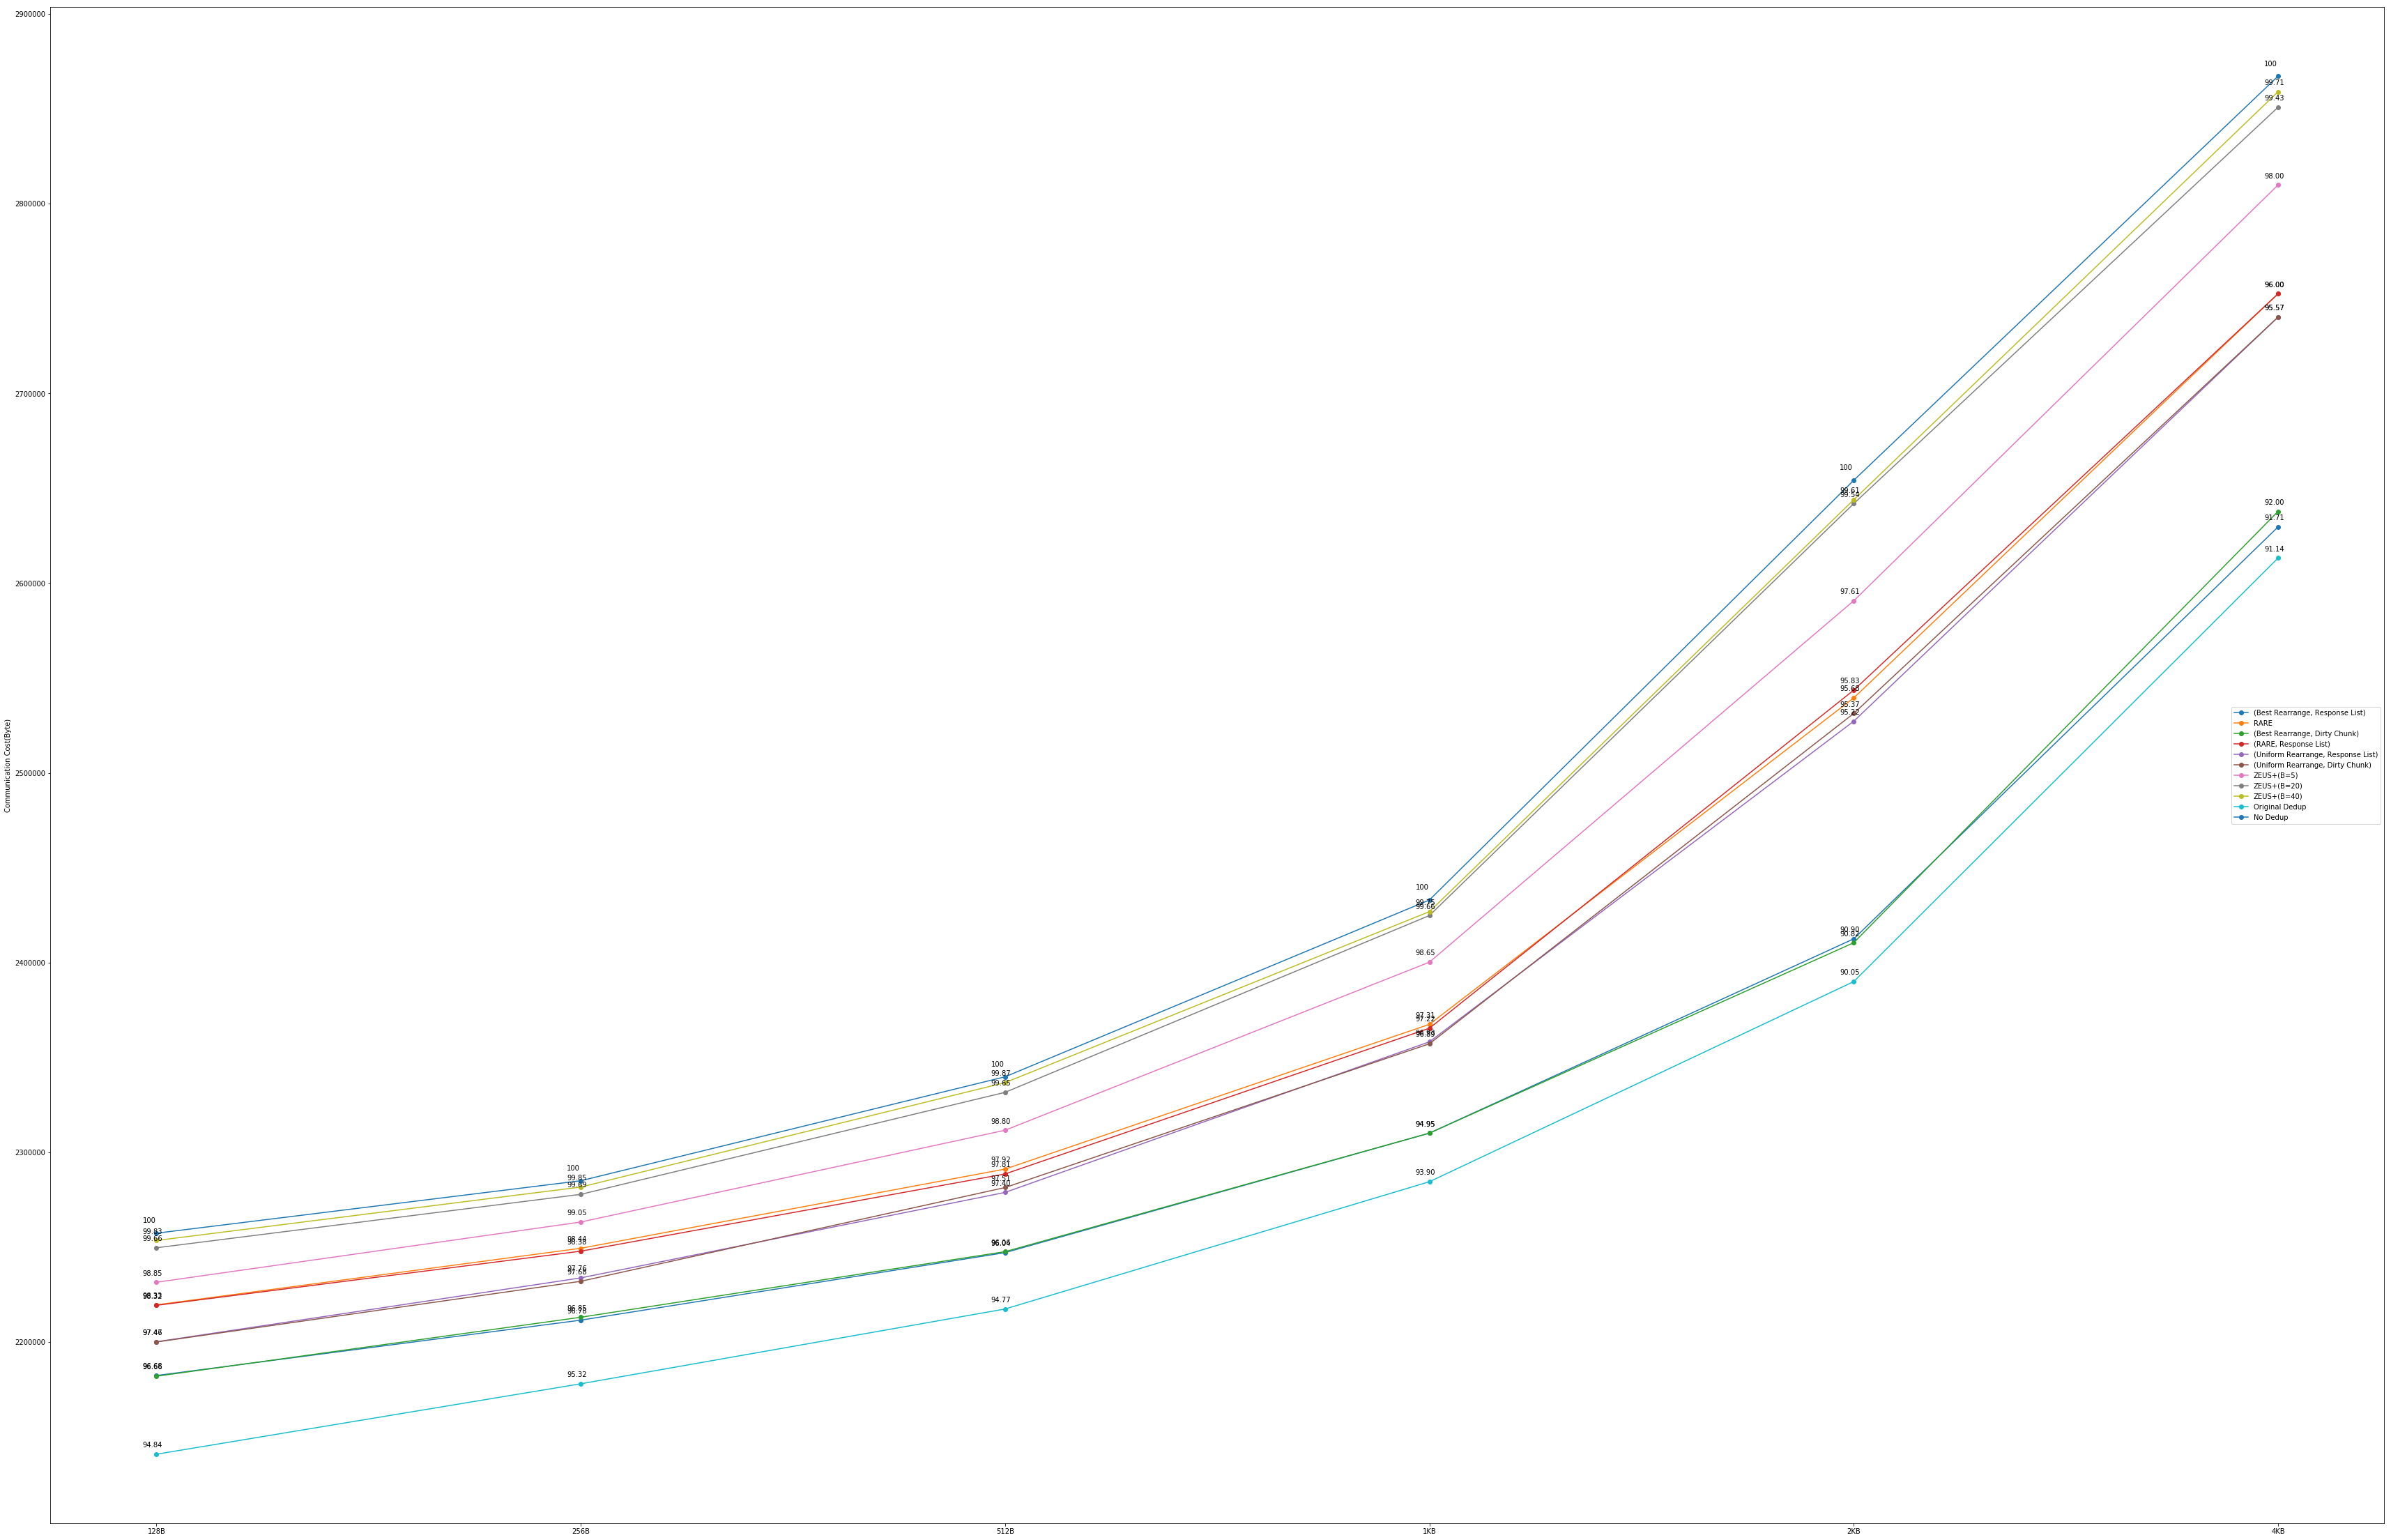

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize = (60, 40))
# plt.figure(dpi = 120)
xs = ['128B', '256B', '512B', '1KB', '2KB', '4KB']
plt.plot(xs, new_byte, '-o', label = '(Best Rearrange, Response List)')
for x, y, z in zip(xs, new_upload_percentage, new_byte):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')

plt.plot(xs, rare_byte, '-o', label = 'RARE')
for x, y, z in zip(xs, rare_upload_percentage, rare_byte):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')
    
plt.plot(xs, rrare_byte, '-o', label = '(Best Rearrange, Dirty Chunk)')
for x, y, z in zip(xs, rrare_upload_percentage, rrare_byte):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')
    
plt.plot(xs, rarerl_byte, '-o', label = '(RARE, Response List)')
for x, y, z in zip(xs, rarerl_upload_percentage, rarerl_byte):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')
    
plt.plot(xs, urrl_byte, '-o', label = '(Uniform Rearrange, Response List)')
for x, y, z in zip(xs, urrl_upload_percentage, urrl_byte):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')
    
plt.plot(xs, rrrare_byte, '-o', label = '(Uniform Rearrange, Dirty Chunk)')
for x, y, z in zip(xs, rrrare_upload_percentage, rrrare_byte):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')

plt.plot(xs, zeus5_byte, '-o', label = 'ZEUS+(B=5)')
for x, y, z in zip(xs, zeus5_upload_percentage, zeus5_byte):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')
    
plt.plot(xs, zeus20_byte, '-o', label = 'ZEUS+(B=20)')
for x, y, z in zip(xs, zeus20_upload_percentage, zeus20_byte):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')
    
plt.plot(xs, zeus40_byte, '-o', label = 'ZEUS+(B=40)')
for x, y, z in zip(xs, zeus40_upload_percentage, zeus40_byte):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')
    
plt.plot(xs, dedup_byte, '-o', label = 'Original Dedup')
for x, y, z in zip(xs, dedup_upload_percentage, dedup_byte):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')
    
plt.plot(xs, no_dedup_byte, '-o', label = 'No Dedup')
for x, y in zip(xs, no_dedup_byte):
    plt.annotate("100", xy = (x,y), xytext=(-20, 15), textcoords='offset points')
    
plt.legend(loc = 7)
plt.ylabel('Communication Cost(Byte)')
# plt.show()
plt.savefig('algo_compare.png')

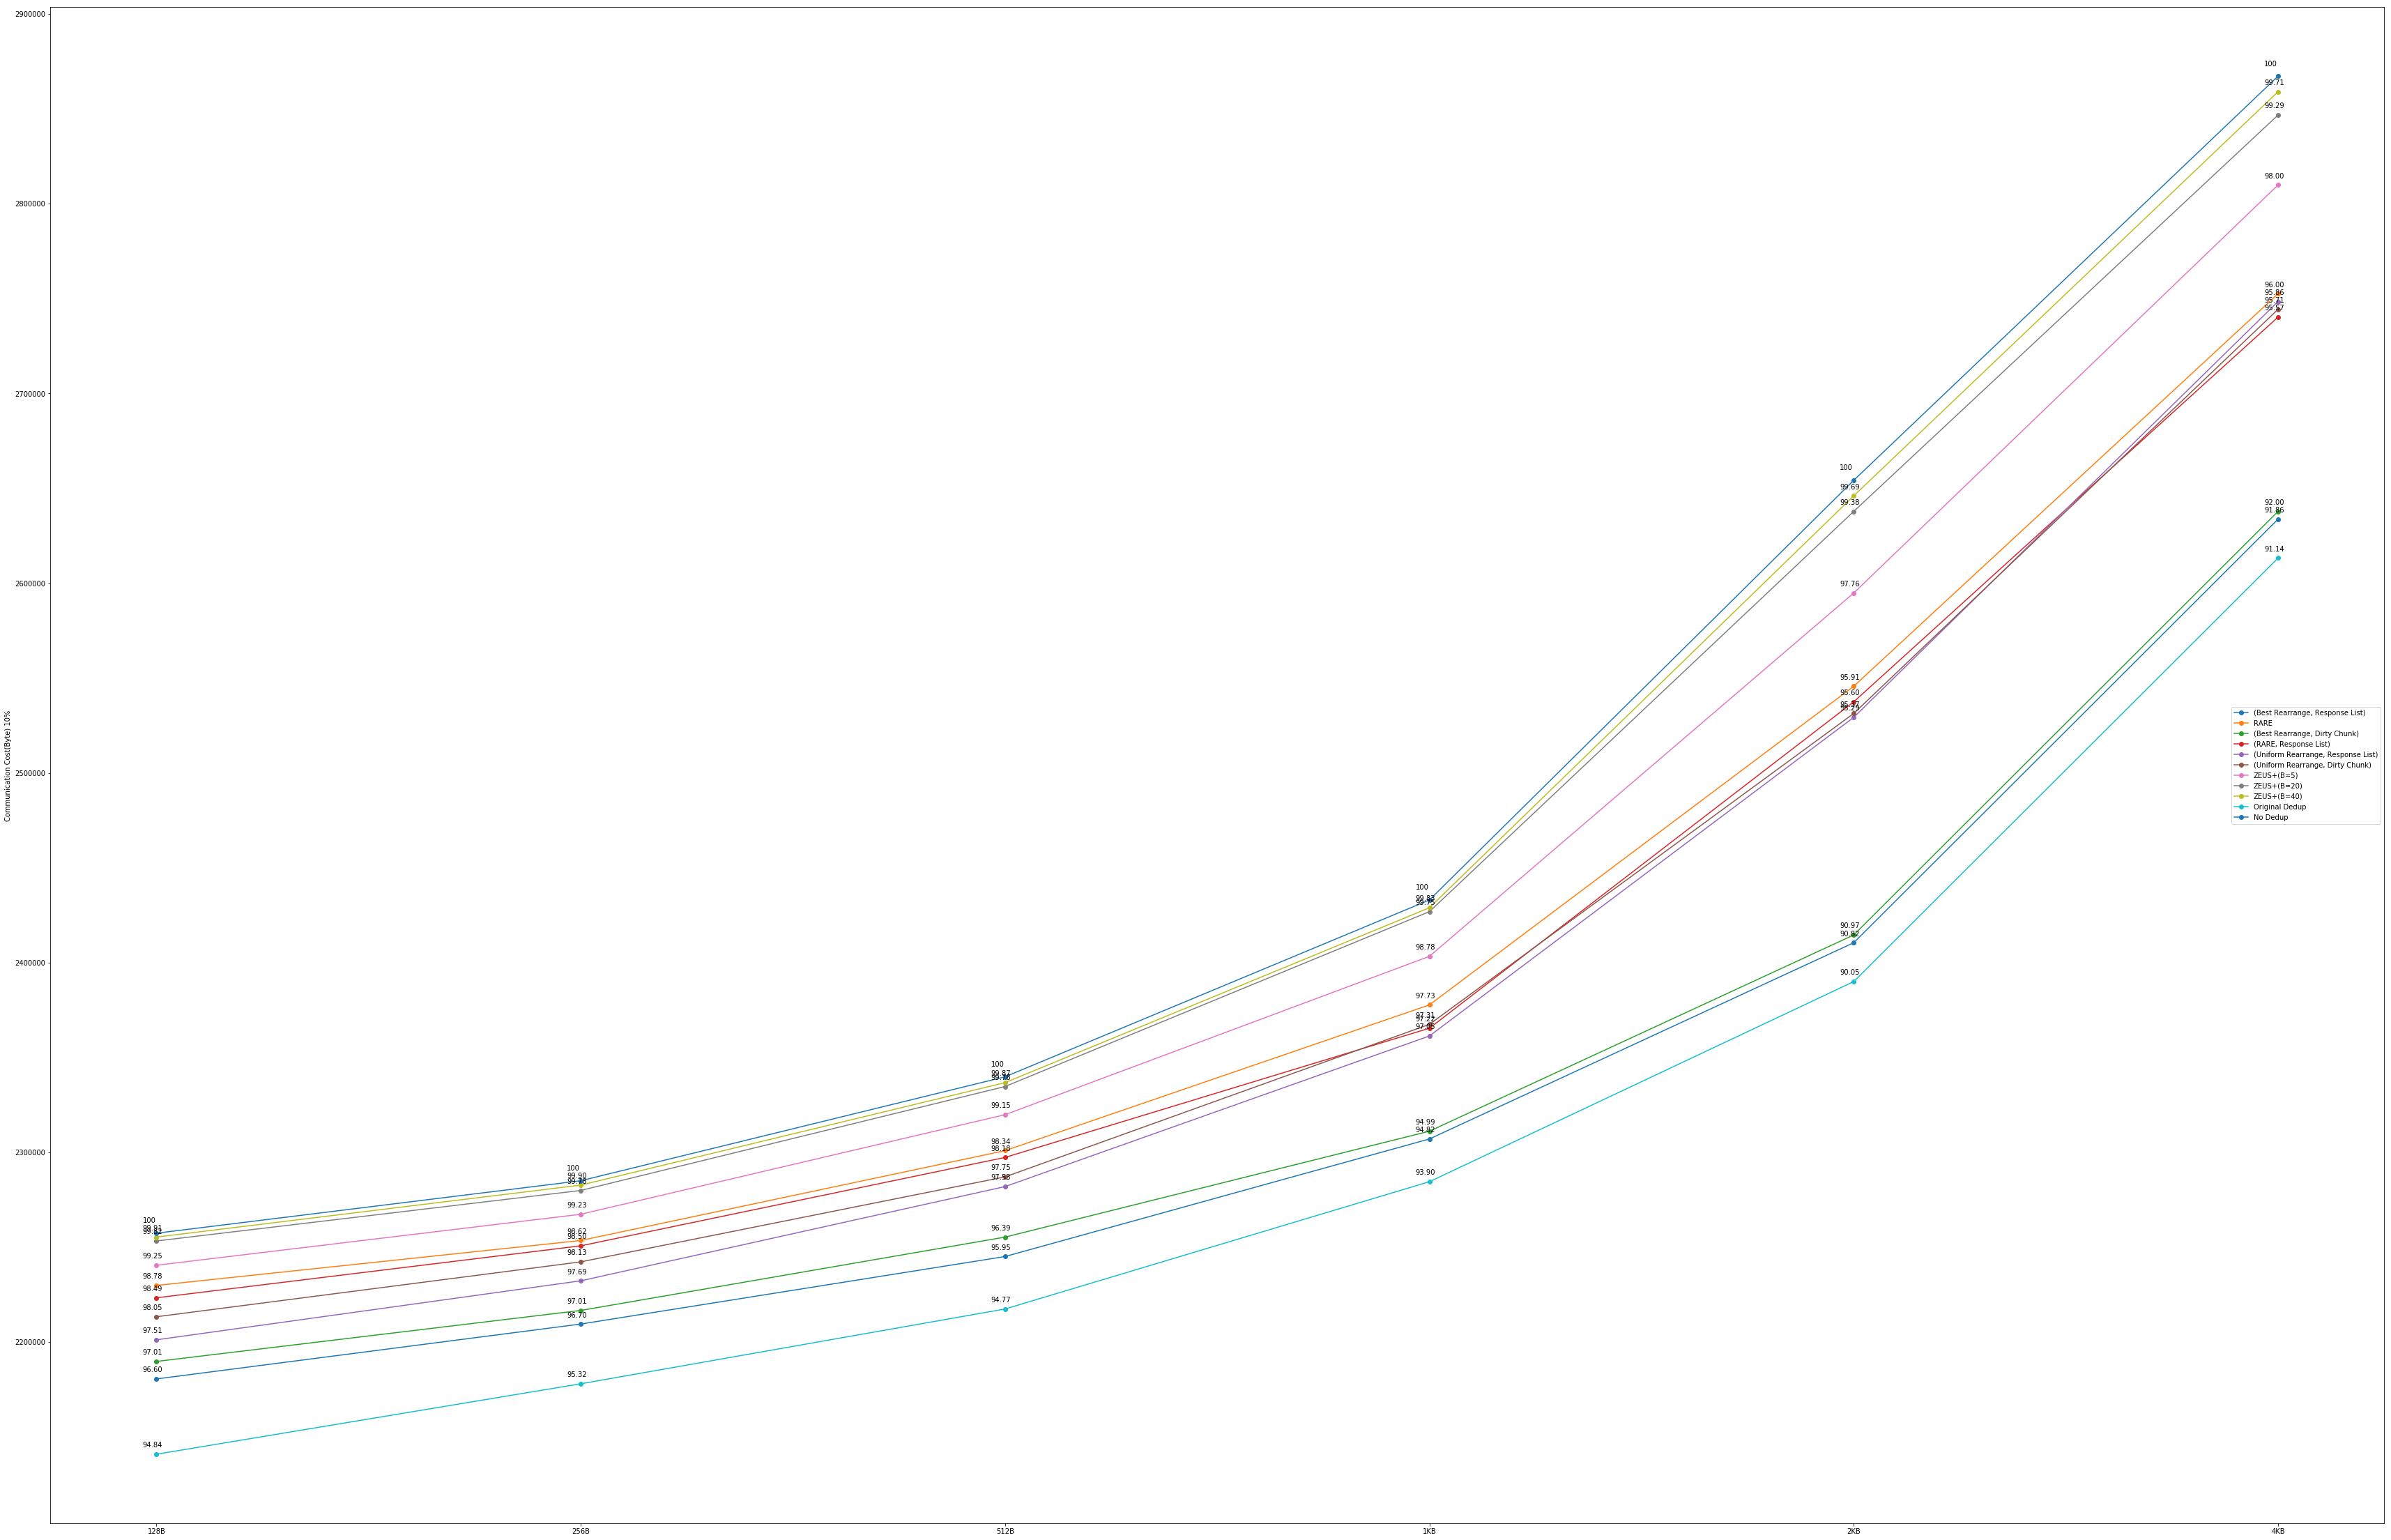

In [52]:
plt.figure(figsize = (60, 40))
# plt.figure(dpi = 120)
xs = ['128B', '256B', '512B', '1KB', '2KB', '4KB']
plt.plot(xs, new_byte_10, '-o', label = '(Best Rearrange, Response List)')
for x, y, z in zip(xs, new_upload_percentage_10, new_byte_10):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')

plt.plot(xs, rare_byte_10, '-o', label = 'RARE')
for x, y, z in zip(xs, rare_upload_percentage_10, rare_byte_10):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')
    
plt.plot(xs, rrare_byte_10, '-o', label = '(Best Rearrange, Dirty Chunk)')
for x, y, z in zip(xs, rrare_upload_percentage_10, rrare_byte_10):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')
    
plt.plot(xs, rarerl_byte_10, '-o', label = '(RARE, Response List)')
for x, y, z in zip(xs, rarerl_upload_percentage_10, rarerl_byte_10):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')
    
plt.plot(xs, urrl_byte_10, '-o', label = '(Uniform Rearrange, Response List)')
for x, y, z in zip(xs, urrl_upload_percentage_10, urrl_byte_10):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')
    
plt.plot(xs, rrrare_byte_10, '-o', label = '(Uniform Rearrange, Dirty Chunk)')
for x, y, z in zip(xs, rrrare_upload_percentage_10, rrrare_byte_10):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')

plt.plot(xs, zeus5_byte_10, '-o', label = 'ZEUS+(B=5)')
for x, y, z in zip(xs, zeus5_upload_percentage_10, zeus5_byte_10):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')
    
plt.plot(xs, zeus20_byte_10, '-o', label = 'ZEUS+(B=20)')
for x, y, z in zip(xs, zeus20_upload_percentage_10, zeus20_byte_10):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')
    
plt.plot(xs, zeus40_byte_10, '-o', label = 'ZEUS+(B=40)')
for x, y, z in zip(xs, zeus40_upload_percentage_10, zeus40_byte_10):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')
    
plt.plot(xs, dedup_byte, '-o', label = 'Original Dedup')
for x, y, z in zip(xs, dedup_upload_percentage, dedup_byte):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')
    
plt.plot(xs, no_dedup_byte, '-o', label = 'No Dedup')
for x, y in zip(xs, no_dedup_byte):
    plt.annotate("100", xy = (x,y), xytext=(-20, 15), textcoords='offset points')
    
plt.legend(loc = 7)
plt.ylabel('Communication Cost(Byte) 10%')
# plt.show()
plt.savefig('algo_compare_10.png')

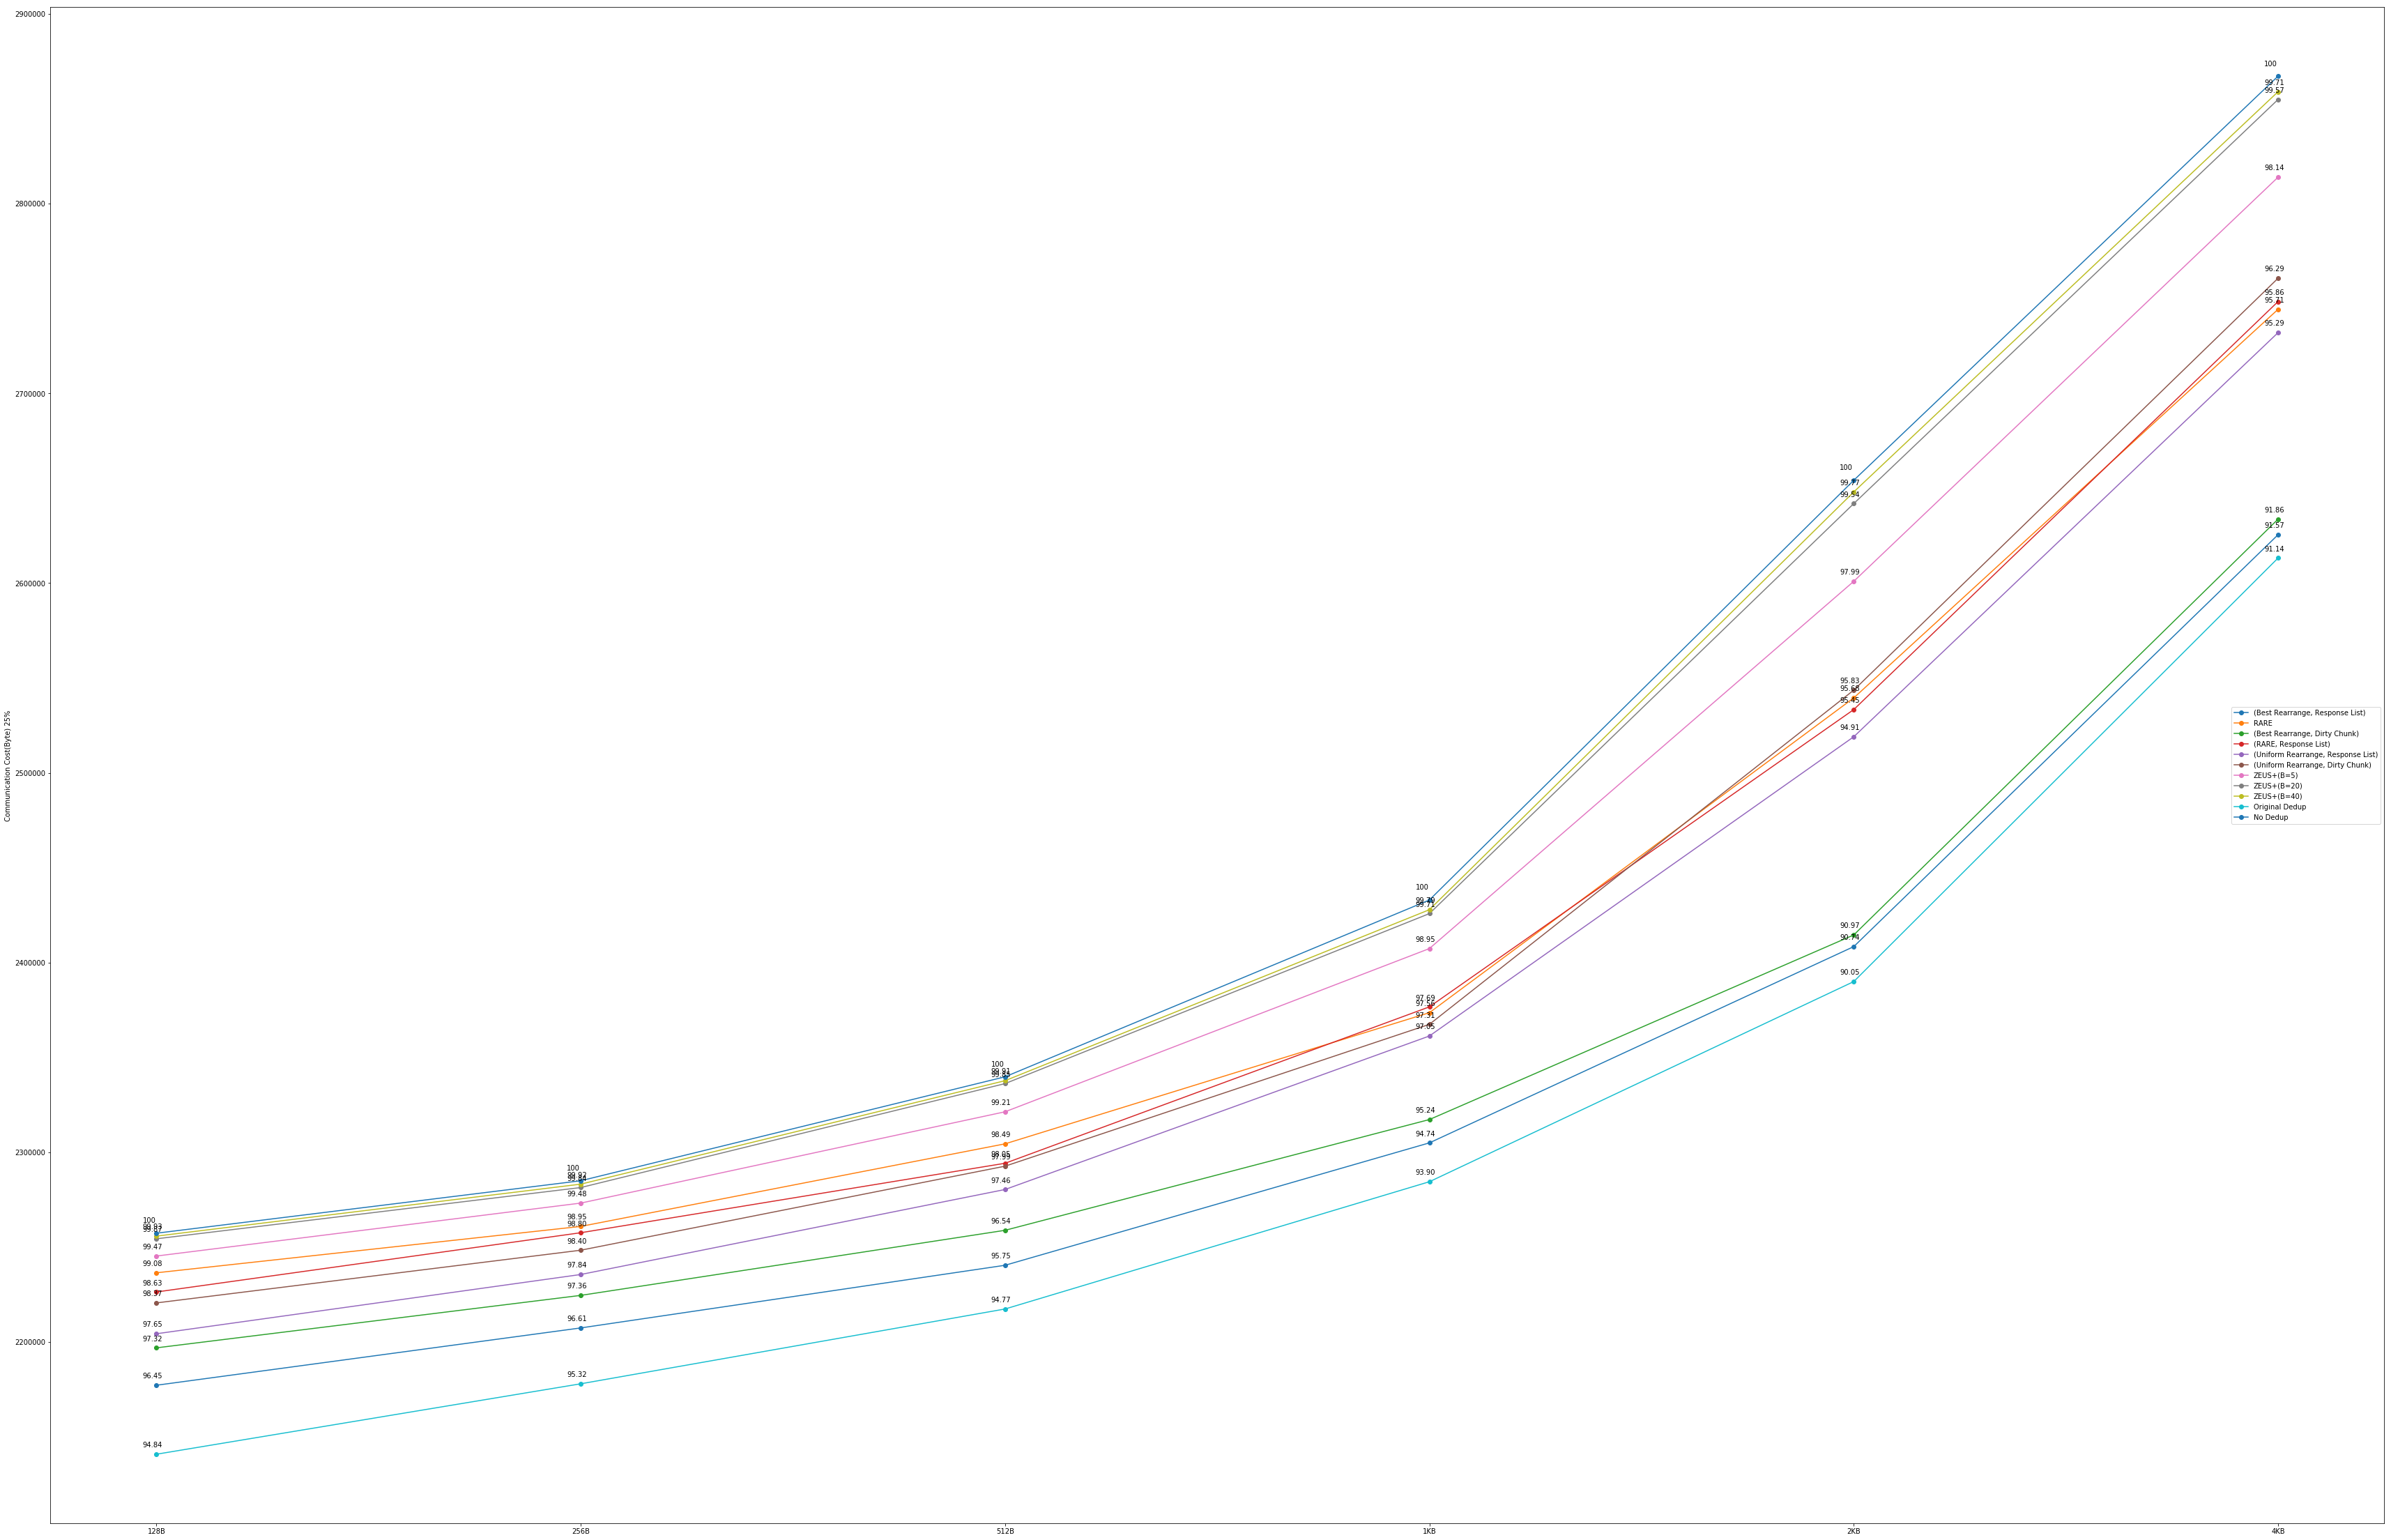

In [53]:
plt.figure(figsize = (60, 40))
# plt.figure(dpi = 120)
xs = ['128B', '256B', '512B', '1KB', '2KB', '4KB']
plt.plot(xs, new_byte_25, '-o', label = '(Best Rearrange, Response List)')
for x, y, z in zip(xs, new_upload_percentage_25, new_byte_25):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')

plt.plot(xs, rare_byte_25, '-o', label = 'RARE')
for x, y, z in zip(xs, rare_upload_percentage_25, rare_byte_25):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')
    
plt.plot(xs, rrare_byte_25, '-o', label = '(Best Rearrange, Dirty Chunk)')
for x, y, z in zip(xs, rrare_upload_percentage_25, rrare_byte_25):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')
    
plt.plot(xs, rarerl_byte_25, '-o', label = '(RARE, Response List)')
for x, y, z in zip(xs, rarerl_upload_percentage_25, rarerl_byte_25):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')
    
plt.plot(xs, urrl_byte_25, '-o', label = '(Uniform Rearrange, Response List)')
for x, y, z in zip(xs, urrl_upload_percentage_25, urrl_byte_25):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')
    
plt.plot(xs, rrrare_byte_25, '-o', label = '(Uniform Rearrange, Dirty Chunk)')
for x, y, z in zip(xs, rrrare_upload_percentage_25, rrrare_byte_25):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')

plt.plot(xs, zeus5_byte_25, '-o', label = 'ZEUS+(B=5)')
for x, y, z in zip(xs, zeus5_upload_percentage_25, zeus5_byte_25):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')
    
plt.plot(xs, zeus20_byte_25, '-o', label = 'ZEUS+(B=20)')
for x, y, z in zip(xs, zeus20_upload_percentage_25, zeus20_byte_25):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')
    
plt.plot(xs, zeus40_byte_25, '-o', label = 'ZEUS+(B=40)')
for x, y, z in zip(xs, zeus40_upload_percentage_25, zeus40_byte_25):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')
    
plt.plot(xs, dedup_byte, '-o', label = 'Original Dedup')
for x, y, z in zip(xs, dedup_upload_percentage, dedup_byte):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')
    
plt.plot(xs, no_dedup_byte, '-o', label = 'No Dedup')
for x, y in zip(xs, no_dedup_byte):
    plt.annotate("100", xy = (x,y), xytext=(-20, 15), textcoords='offset points')
    
plt.legend(loc = 7)
plt.ylabel('Communication Cost(Byte) 25%')
# plt.show()
plt.savefig('algo_compare_25.png')

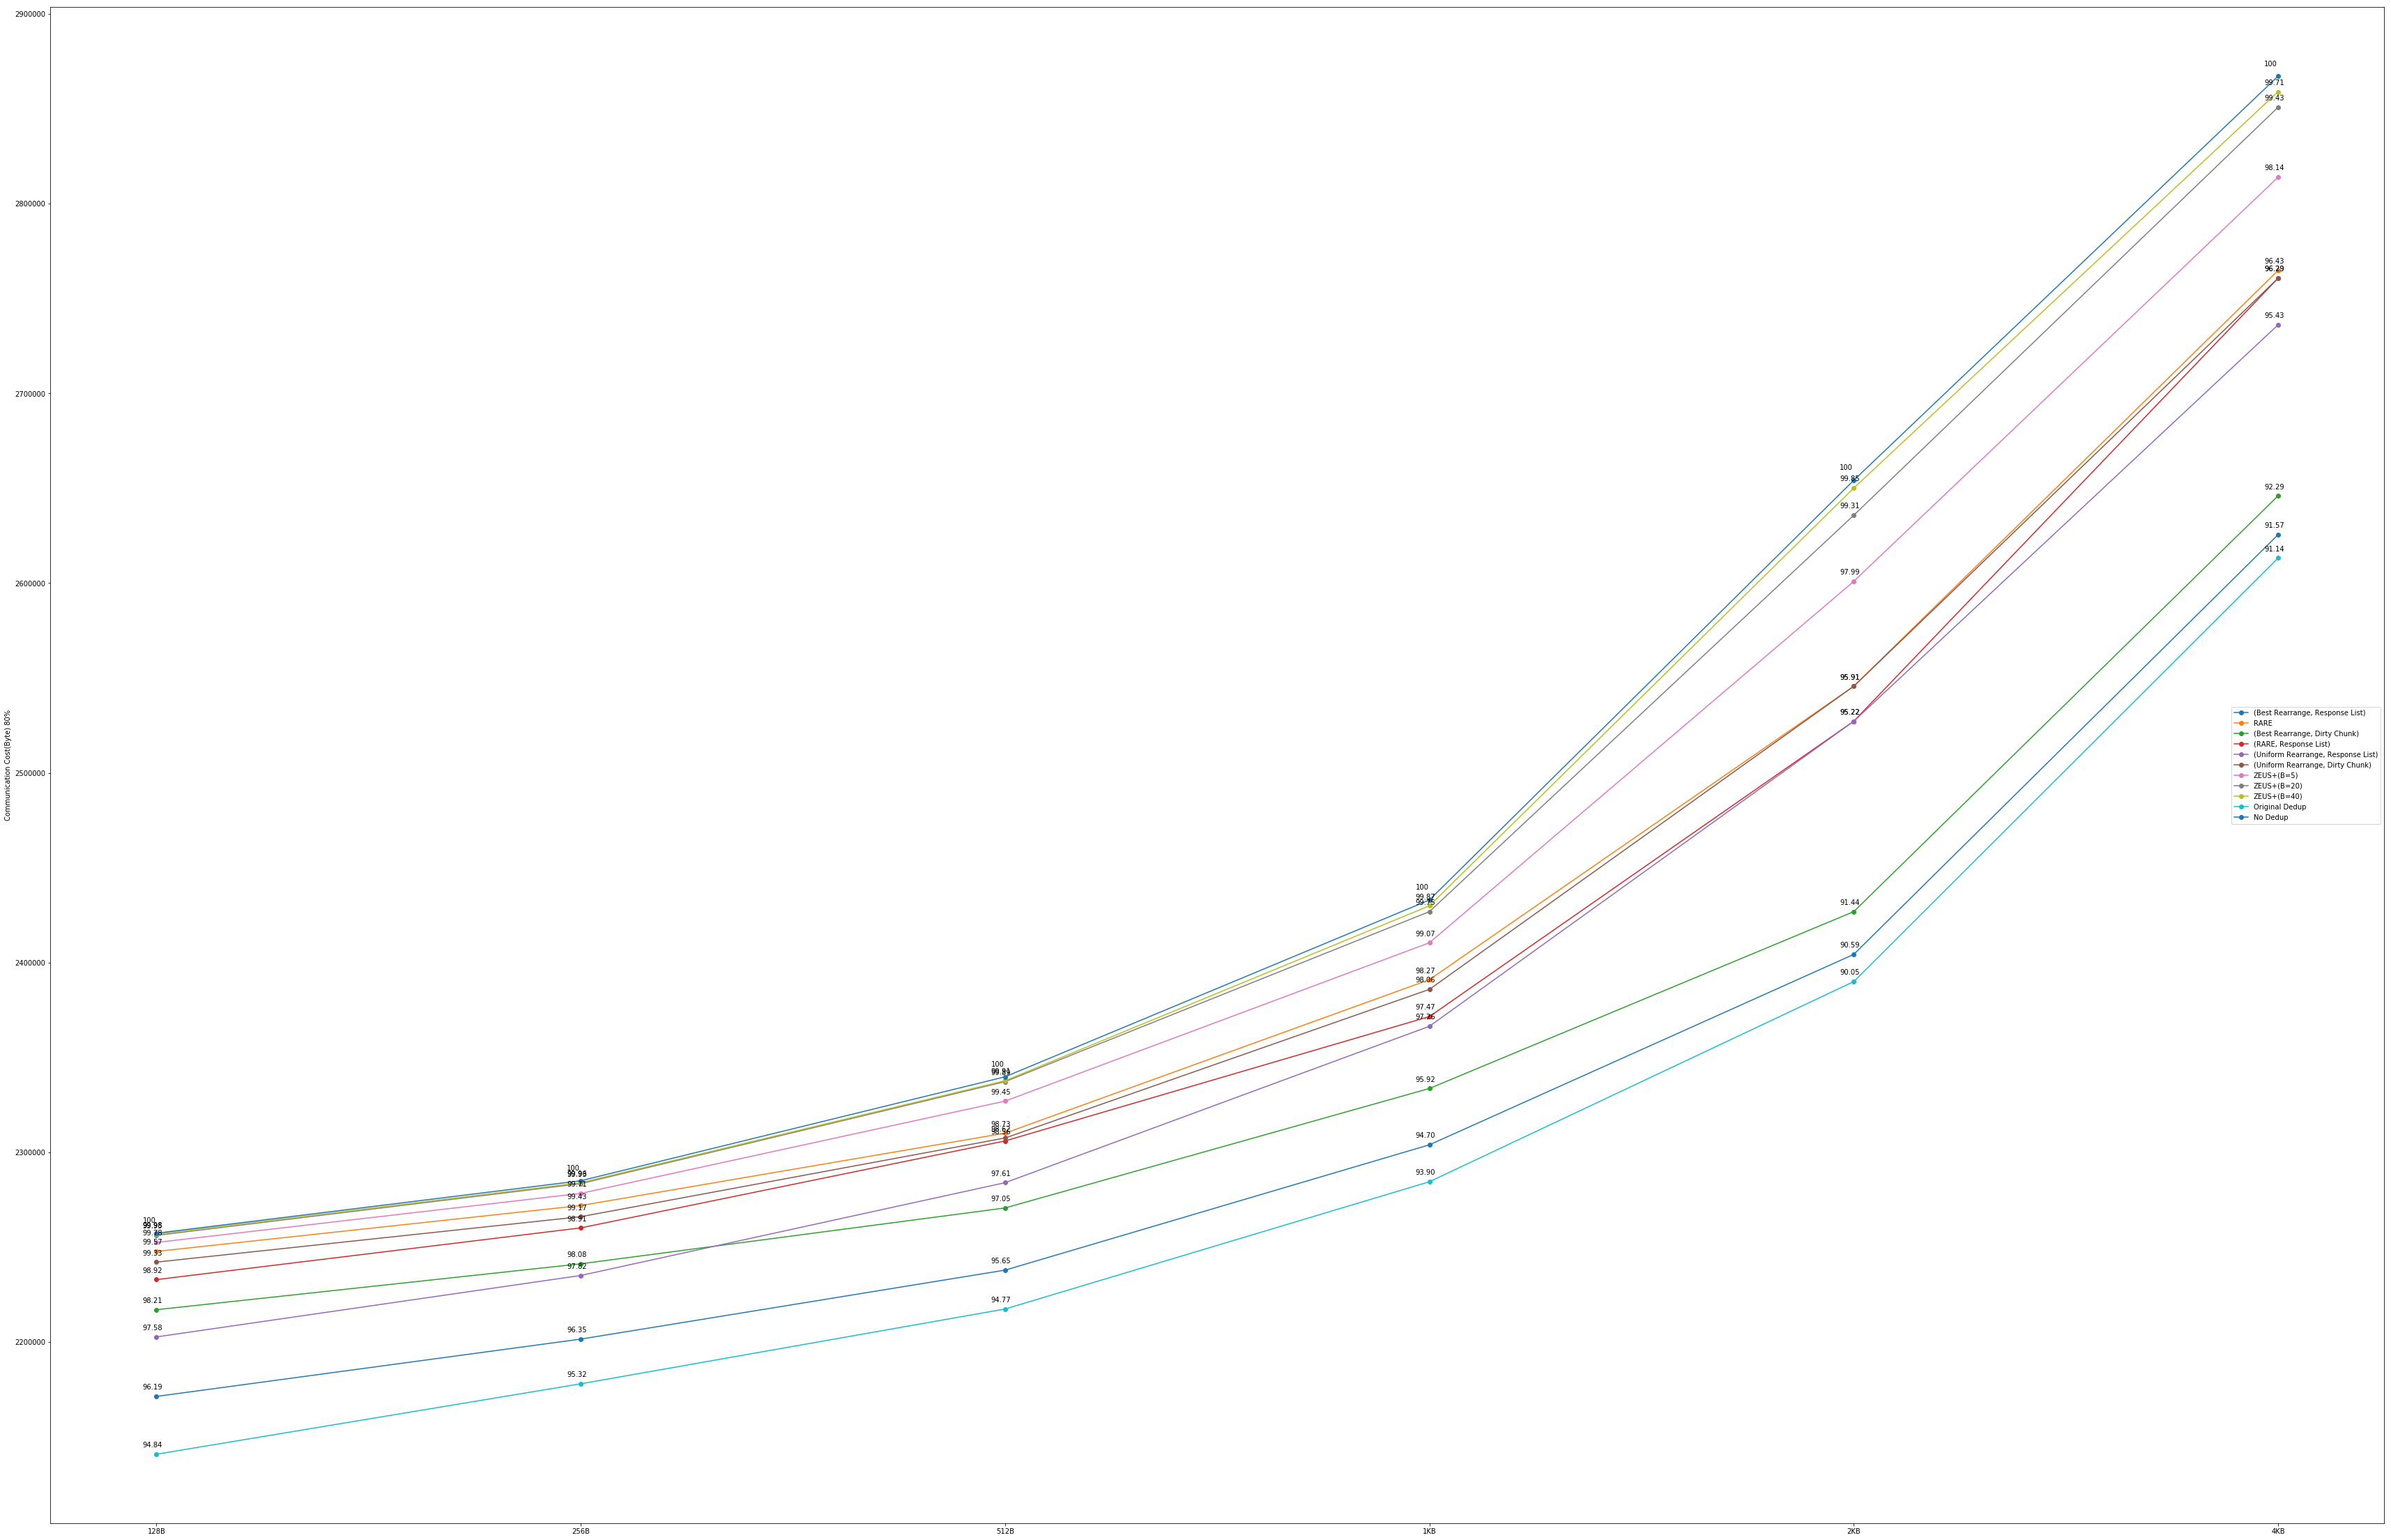

In [54]:
plt.figure(figsize = (60, 40))
# plt.figure(dpi = 120)
xs = ['128B', '256B', '512B', '1KB', '2KB', '4KB']
plt.plot(xs, new_byte_80, '-o', label = '(Best Rearrange, Response List)')
for x, y, z in zip(xs, new_upload_percentage_80, new_byte_80):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')

plt.plot(xs, rare_byte_80, '-o', label = 'RARE')
for x, y, z in zip(xs, rare_upload_percentage_80, rare_byte_80):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')
    
plt.plot(xs, rrare_byte_80, '-o', label = '(Best Rearrange, Dirty Chunk)')
for x, y, z in zip(xs, rrare_upload_percentage_80, rrare_byte_80):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')
    
plt.plot(xs, rarerl_byte_80, '-o', label = '(RARE, Response List)')
for x, y, z in zip(xs, rarerl_upload_percentage_80, rarerl_byte_80):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')
    
plt.plot(xs, urrl_byte_80, '-o', label = '(Uniform Rearrange, Response List)')
for x, y, z in zip(xs, urrl_upload_percentage_80, urrl_byte_80):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')
    
plt.plot(xs, rrrare_byte_80, '-o', label = '(Uniform Rearrange, Dirty Chunk)')
for x, y, z in zip(xs, rrrare_upload_percentage_80, rrrare_byte_80):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')

plt.plot(xs, zeus5_byte_80, '-o', label = 'ZEUS+(B=5)')
for x, y, z in zip(xs, zeus5_upload_percentage_80, zeus5_byte_80):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')
    
plt.plot(xs, zeus20_byte_80, '-o', label = 'ZEUS+(B=20)')
for x, y, z in zip(xs, zeus20_upload_percentage_80, zeus20_byte_80):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')
    
plt.plot(xs, zeus40_byte_80, '-o', label = 'ZEUS+(B=40)')
for x, y, z in zip(xs, zeus40_upload_percentage_80, zeus40_byte_80):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')
    
plt.plot(xs, dedup_byte, '-o', label = 'Original Dedup')
for x, y, z in zip(xs, dedup_upload_percentage, dedup_byte):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')
    
plt.plot(xs, no_dedup_byte, '-o', label = 'No Dedup')
for x, y in zip(xs, no_dedup_byte):
    plt.annotate("100", xy = (x,y), xytext=(-20, 15), textcoords='offset points')
    
plt.legend(loc = 7)
plt.ylabel('Communication Cost(Byte) 80%')
# plt.show()
plt.savefig('algo_compare_80.png')